# Brock Mirman (1972) model: create plots

## Description

This the textbook neogrowth model with known (linear solution). Consider an agent maximizing her inter-temporal discounted utility
\begin{equation}
\begin{split}
\max_{\{c_t\}_{t=0}^{\infty}} E\Big[ \sum_{t=0}^{\infty} \beta^t u(c_t)\Big]
\end{split}
\end{equation}
with $y_0$ given. She enters period $t$ with income $y_t$ and chooses her consumption level $c_t$ subject to the constraints $0\leq c_t \leq y_t$. What is saved in the current period is used for production to generate income next period.

Income next period is stochastic and takes the following form: $y_{t+1} = g(y_t - c_t)\eta_{t+1}$ with $\eta$ denoting i.i.d. productivity shocks.

Let us assume that preferences can be represented by a logarithmic utility function $u(c)=\log(c)$, the production function is Cobb-Douglas $g(k) = k^\alpha$, the discount factor is positive but strictly less than one, $\beta \in (0,1)$, and that productivity shocks are lognormally distributed $\eta_{t} \equiv \eta(\nu_t) = \exp(\mu + \nu_t)$, with $\nu$ a standard Normal random variable.

Solving the model involves finding the value of parameter vector $\theta$ such that the consumption function $c(y|\theta)$ satisfies the Euler equation characterizing the model:

\begin{equation}\label{eq:Euler_sgm}
E_{\nu}\Big[ \beta \frac{c_t}{c_{t+1}} \alpha k_t^{\alpha -1}\exp(\nu_{t+1})  \Big] = 1
\end{equation}

Greater tractability is achieved by working with a transformed version of the left-hand side of the previous equation:
\begin{equation}\label{eq:Euler_sgm_transformed}
E_{\nu}\Big[ \exp \Big( \log \big( \beta \frac{c_t}{c_{t+1}} \alpha k_t^{\alpha -1}\exp(\nu_{t+1}) \big) \Big) \Big] \approx E_{\nu}\Big[ 1 + \log \big( \alpha \beta ) + \tilde{c}_t - \tilde{c}_{t+1} +(\alpha -1) \tilde{k}_t + \nu_{t+1} \Big) \Big]
\end{equation}

where the tilde notation is used to refer to the logarithm of the variable, for instance $\tilde{c_t} = \log(c_t)$, and making use of the approximation $\exp(x) \approx 1 + x$ for $x$ small. Hence, the Euler equation can be rewritten as
\begin{equation}\label{eq:Euler_sgm_transformed_2}
E_{\nu}\Big[\log \big( \alpha \beta ) + \tilde{c}_t - \tilde{c}_{t+1} +(\alpha -1) \tilde{k}_t +\nu_{t+1} \Big) \Big] = 0
\end{equation}

where $\tilde{y}_{t+1} = \alpha \tilde{k}_t + \nu_{t+1}$ and $\tilde{c}_{t+1} = \log\big(c(y_{t+1}| \theta) \big)$.

It is easy to verify that the optimal behavior for the agent is to consume a fixed fraction of her cash on hand $y$. More specifically, the optimal consumption policy function is given by $c^{*}(y_t) = (1 - \alpha \beta) y_t$, or equivalently $\tilde{c}^{*}(y_t) = (1 - \alpha \beta) + \tilde{y}$.


## The bc-MC Operator

Let's pretend we do not know the solution. We are approximating the decision function with a artificial neural network (ANN) $c(y) \approx c(y|\theta)$. The loss function for the ANN is:

$$\mathcal{L}(\theta) =  E_{s}\Big( E_{s}\Big( f(s, \varepsilon) \Big)^2 \Big) $$

Let's approximate the loss function with the bc-MC operator:

$$\mathcal{L}_{M,N}(\theta) = \frac{2}{MN(N-1)} \sum_{m=1}^{M} \sum_{1\leq i < j}^{n} f(s_m, \epsilon_{m}^{(i)})f(s_m, \epsilon_{m}^{(j)}) $$

where $\epsilon^{(k)}$ for $k=1, 2, ..., N$ are $N$ i.i.d shocks with the same distribution as $\epsilon$. These $N$ shocks are independent from each other.

## Variance of the loss function

\begin{equation}\label{eq:variance_loss_1}
\begin{split}
Var(\mathcal{L}^{U}_{M,N}(\theta)) & = \frac{1}{T(N-1)}\Big[ Var \big(f(s_m, \varepsilon^{1}_{m}|\theta) f(s_m, \varepsilon^{2}_{m}|\theta)\big) \\
& + 2 \big(N-2) Cov (f(s_m, \varepsilon^{1}_{m}|\theta) f(s_m, \varepsilon^{2}_{m}|\theta), f(s_m, \varepsilon^{1}_{m}|\theta) f(s_m, \varepsilon^{3}_{m}|\theta) ) \\
& + 2 \Big(\frac{N(N-1)}{4} - N + \frac{3}{2} \Big) Cov(f(s_m, \varepsilon^{1}_{m}|\theta) f(s_m, \varepsilon^{2}_{m}|\theta), f(s_m, \varepsilon^{3}_{m}|\theta) f(s_m, \varepsilon^{4}_{m}|\theta) \big) \Big]
\end{split}
\end{equation}
where $\varepsilon^{1}$, $\varepsilon^{2}$, $\varepsilon^{3}$ and $\varepsilon^{4}$ are four independent random variables, with the same distribution as $\varepsilon$.

## Time-varying N

In section III of this notebook, I vary N during training, **using the Gaussian formula. **


## Structure of this notebook

    0. Dependencies
        Load dependencies and set some parameters
    I. Test the variance formula from proposition 4
    II. Calculate variance of the loss across iterations
    III. Vary the optimal M and N during training


## 0. Dependencies

Load packages and define some options and parameters.

In [1]:
on_Colab = False
# Install deps on Colab
if on_Colab == True:
    !pip install quantecon interpolation chaospy torchcontrib

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import quantecon as qe
from interpolation import interp
from quantecon.optimize import brentq
from numba import njit, float64
from numba.experimental import jitclass

import random
import scipy.stats
import chaospy  ## for quadrature (expectations)
from itertools import product
import os

import tensorflow as tf
import time
from math import sqrt
import seaborn as sns; sns.set()
from tqdm import tqdm as tqdm # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass
from scipy.stats import norm

import torch
from torch import nn
from torch.utils.data import DataLoader
# To create copies of NN
import copy
# To use sparse kronecker product
from scipy import sparse
from torchcontrib.optim import SWA
from torch.nn.utils import clip_grad_norm_

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.special import erfinv, erf

import platform,socket,re,uuid,json,psutil,logging, cpuinfo, shutil

2024-01-05 09:04:05.492229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-05 09:04:05.492293: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
cpuinfo.get_cpu_info()

{'python_version': '3.8.10.final.0 (64 bit)',
 'cpuinfo_version': [9, 0, 0],
 'cpuinfo_version_string': '9.0.0',
 'arch': 'X86_64',
 'bits': 64,
 'count': 12,
 'arch_string_raw': 'x86_64',
 'vendor_id_raw': 'GenuineIntel',
 'brand_raw': 'Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz',
 'hz_advertised_friendly': '2.6000 GHz',
 'hz_actual_friendly': '3.8625 GHz',
 'hz_advertised': [2600000000, 0],
 'hz_actual': [3862521000, 0],
 'stepping': 10,
 'model': 158,
 'family': 6,
 'flags': ['3dnowprefetch',
  'abm',
  'acpi',
  'adx',
  'aes',
  'aperfmperf',
  'apic',
  'arat',
  'arch_capabilities',
  'arch_perfmon',
  'art',
  'avx',
  'avx2',
  'bmi1',
  'bmi2',
  'bts',
  'clflush',
  'clflushopt',
  'cmov',
  'constant_tsc',
  'cpuid',
  'cpuid_fault',
  'cx16',
  'cx8',
  'de',
  'ds_cpl',
  'dtes64',
  'dtherm',
  'dts',
  'epb',
  'ept',
  'ept_ad',
  'erms',
  'est',
  'f16c',
  'flexpriority',
  'flush_l1d',
  'fma',
  'fpu',
  'fsgsbase',
  'fxsr',
  'hle',
  'ht',
  'hwp',
  'hwp_act_wi

In [4]:
# Display version of python currently used
!python3 --version

Python 3.8.10


In [5]:
seed_number = 1234 #1234
random.seed(seed_number) # For replicability reasons
print(random.random())
torch.manual_seed(seed_number)

0.9664535356921388


In [6]:
# Plotting options
plot_scale = 1.25
plt.rcParams["figure.figsize"] = (plot_scale*16, plot_scale*9)
# Controlling fontsizes
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE =  SMALL_SIZE + 4
plt.rcParams['legend.fontsize'] = MEDIUM_SIZE

# Option when reading and saving output csv.file
read_from_csv = True #read from disk
save_to_csv = False #save to disk
run_analysis = False #start the analysis (can be very long)

plt.rcParams.update({"text.usetex": True})

In [7]:
%run functions_BM.ipynb
current_wd = os.getcwd()

In [8]:
# Store parameters
class MyParams():
    def __init__(self, N, M, lr, pre_train_model, nb_epochs, order_gauss, σ_e, use_Sobol, optimizer,
                α_chosen, β_chosen, e_distribution_chosen, x_distribution_chosen):
        # Safety checks:
        if α_chosen > 1:
            raise Exception(f"α = {α_chosen} bigger than 1")
        if β_chosen > 1:
            raise Exception(f"β = {β_chosen} bigger than 1")
        # distribution shocks
        ## "Lognormal": legacy from WP version. contains a typo
        ## "Lognormal_2": lognormal (log(e_t) then is normal)
        ## "Beta": beta distribion
        ## "Trunc_Lognormal": lognormal, but truncated:
        ## "Normal": normal distribution
        self.list_e_distribution_allowed = ["Lognormal_2", "Beta", "Trunc_Lognormal", "Lognormal", "Normal"]
        # disribution state
        ## "Lognormal_2": lognormal (log(y_t) then is normal). Use ergodic distribution of log(y_t)
        ## "Lognormal_3": lognormal (log(y_t) then is normal). Std. dev different from true ergodic distribution.
        ## "Uniform": y_t from Uniform
        ## "Normal": y_t from normal
        ## "Uniform_centered": y_t from uniform, centered around ss for y_t
        self.x_distribution_allowed = ["Lognormal_2", "Lognormal_3", "Uniform", "Normal", "Uniform_centered"]
        if e_distribution_chosen not in  self.list_e_distribution_allowed:
            raise Exception(f"e_distribution_chosen: {e_distribution_chosen} not allowed")
        if x_distribution_chosen not in   self.x_distribution_allowed:
            raise Exception(f"x_distribution_chosen: {x_distribution_chosen} not allowed")
        # OptimalGrowthModel
        self.α = α_chosen #0.4 #0.4 #0.9 #0.4 #0.4
        self.β = β_chosen #0.99 #0.96 #0.96 #0.96#
        self.f = lambda k: k**self.α
        self.u = lambda c: np.log(c)
        self.f_prime = lambda k: self.α * (k**(self.α - 1))
        self.u_prime=  lambda c: 1/c
        self.u_prime_inv =  lambda c: 1/c
        # True function
        self.true_cst = (1 - self.α * self.β) #true constant param
        ## True bias and true weight make sense when the network is just sigmoid(nn.Sequential(nn.Linear(1, 1)))
        self.true_bias = (torch.logit(torch.tensor([self.true_cst]))).detach().numpy() #true bias of the ANN
        self.true_weight = 0.0 #true weight of the ANN
        true_function = lambda x: self.true_cst * x #True solution
        self.true_function = true_function
        # Non-stochastic SS
        self.y_ss = (self.α*self.β)**(self.α/(1 - self.α))
        self.k_ss = (self.α*self.β)**(1/(1 - self.α))
        self.c_ss = self.true_function(self.y_ss)
        # Standard shocks
        #σ_e = σ_e # for large shocks, it is better to use MC, for small shock: all-in-one
        #μ_e = 0.0 #location parameter shocks
        # Values passed as inputs
        self.N = N #number of draws inside expectation
        self.M = M #number of draws outside expecation
        self.MN = int(self.M*self.N)
        # To keep constant the number of function evaluations
        self.T = int(self.MN/2) #number of draws all in on expectation
        self.σ_e = σ_e
        self.μ_e = 0.0
        self.e_distribution = e_distribution_chosen #"Lognormal_2" #"Lognormal_2" #"Beta" #"Trunc_Lognormal" #"Lognormal_2" #"Normal"
        # When working with truncated distributions
        self.trunc_low = -4 #0.5 #-1 #-2
        self.trunc_high = 2 #0.5 #1 #2
        # Simulate true model
        self.df_series, self.series_names, self.list_mean, self.list_std, self.list_CI_lower, self.list_CI_upper = sim_true_model(self.α, self.β, self.f, self.e_distribution, self.μ_e, self.σ_e, self.trunc_low, self.trunc_high, 10000)
        # Standard error X (if drawing from Normal)
        self.σ_x = 1.0
        self.x_distribution = x_distribution_chosen #"Lognormal_2" #"Lognormal_2" #"Uniform" #"Normal" #Uniform or Normal or "Lognormal_2"
        # Draw from model
        x_low = self.list_CI_lower[self.series_names.index('y')] #params.list_CI_lower[params.series_names.index('y')] #0.5 ##0.1 #1
        x_high = self.list_CI_upper[self.series_names.index('y')] #params.list_CI_upper[params.series_names.index('y')] #1.5 ##4.0 #3
        # When y_t is lognormal. Ergodic distribution at true value
        self.mm = self.α/(1 - self.α)*np.log(self.α*self.β) # mean log(y_t)
        self.ss = np.sqrt((self.σ_e**2)/(1 - self.α**2)) # std log(y_t)
        # When using Lognormal_3 for state
        ## when alpha=0.36 and beta = 0.96
        ##Kappa N*=100: 0.0019935763981368095
        ##Kappa N*=3: 0.019735399459103867
        self.ss_Lognormal_3 = 0.0019 #0.1 #0.0019 #0.1 #0.002 # 0.0019
        #p = 0.05
        #val_p_low = np.exp(mm + np.sqrt(2*(ss**2))*erfinv(2*p - 1))
        #p = 0.95
        #val_p_high = np.exp(mm + np.sqrt(2*(ss**2))*erfinv(2*p - 1))
        if self.e_distribution  == "Trunc_Lognormal":
            self.x_low = np.exp(self.mm + self.ss*self.trunc_low) #
            self.x_high = np.exp(self.mm + self.ss*self.trunc_high) #
        elif self.e_distribution  == "Beta":
            self.x_low = np.exp(self.mm + 0/(1 - self.α)) #
            self.x_high = np.exp(self.mm + 1/(1 - self.α))  #
        elif self.x_distribution  == "Uniform_centered": #Uniform centered at the true mean
            tol_mean = 0.0069/2
            self.x_low = np.exp(self.mm - tol_mean)
            self.x_high = np.exp(self.mm + tol_mean)
        else:
            self.x_low = x_low
            self.x_high =  x_high
        # Vectorized Monte Carlo requires the creation of some objects
        # To repeat vectors
        repeat_vector = torch.ones(N) #to repeat the same value n times using a matrix multiplication
        # To calculate the expectation wrt future shocks using a matrix multiplication
        A = sparse.eye(M)
        B = sparse.csr_matrix(np.ones(N)/N)
        # Sparse kronecker product. Then convert to pytorch sparse
        W = sparse_mx_to_torch_sparse_tensor(sparse.kron(A, B))
        self.repeat_vector = repeat_vector
        self.W = W
        # Use for the bc-MC operator
        self.W_expanded = create_W_expanded_matrix(self.M, self.N)
        # Learning parameters
        self.lr = lr #learning rate
        self.momentum = 0.9 #momentum for SGD with momentum
        self.optimizer = optimizer #"Adam" #default: #Adam or SGD or SWA
        self.freq_gamma = 0.95
        self.use_scheduler = False #False #True #default: True
        self.pre_train_model = pre_train_model #default: False (not used)
        self.nb_epochs = nb_epochs
        self.nb_epochs_pre_train = int(self.nb_epochs/1)
        self.freq_scheduler = 500 #int(self.nb_epochs/10)
        # Sobol sampling
        self.soboleng = torch.quasirandom.SobolEngine(dimension=1)
        self.soboleng_M = torch.quasirandom.SobolEngine(dimension=M)
        self.soboleng_T = torch.quasirandom.SobolEngine(dimension=self.T)
        self.use_Sobol = use_Sobol #Sobol for dimension M
        self.use_Sobol_T = use_Sobol #Sobol for all-in-one
        # GAUSSIAN QUADRATURE
        # self.distrib = chaospy.J(chaospy.Normal(μ_e, σ_e))
        self.distrib = chaospy.LogNormal(self.μ_e, self.σ_e)
        self.order_gauss = order_gauss
        nodes, weights = dist(self.order_gauss, self.distrib, rule = "gaussian", sp=False)
        self.nodes = nodes
        self.weights = weights
        self.weights_torch = torch.tensor(weights)
        self.nodes_torch = torch.tensor(np.transpose(self.nodes).squeeze(1))
        # Save the number of points for the guassian quadrature:
        self.N_gaussian = len(self.weights_torch)
        # Repeat nodes to match the number of function evaluations for the expectation
        #self.nodes_torch_repeated = self.nodes_torch.repeat(self.M)
        # CREATE A W MATRIX FOR GAUSSIAN QUADRATURE:
        #B_gaussian = sparse.csr_matrix(self.weights_torch)
        # Sparse kronecker product. Then convert to pytorch sparse
        #self.W_gaussian = sparse_mx_to_torch_sparse_tensor(sparse.kron(A, B_gaussian))
        # Test points
        self.nb_points_accuracy = 100
        # If uniform
        ## not the ergodic distribution for y
        #self.xvec_test_torch = torch.linspace(self.x_low, self.x_high, self.nb_points_accuracy).unsqueeze(1) #add a dimension
        # If drawing from true ergodic distribution for y
        ## y is lognormal
        self.xvec_test = np.random.lognormal(self.mm, self.ss, size=self.nb_points_accuracy)
        self.f_true = np.expand_dims(self.true_function(self.xvec_test),1) # true value of c(y_t)
        self.xvec_test_torch = torch.tensor(self.xvec_test).unsqueeze(1).float()
        self.n_nodes = len(self.weights_torch)
        # CREATE A W MATRIX FOR GAUSSIAN QUADRATURE:
        self.A_gaussian = sparse.eye(self.nb_points_accuracy)
        self.B_gaussian = sparse.csr_matrix(self.weights_torch)
        # Sparse kronecker product. Then convert to pytorch sparse
        self.W_gaussian = sparse_mx_to_torch_sparse_tensor(sparse.kron(self.A_gaussian, self.B_gaussian))
        self.swa_start = 1000
        self.swa_freq= 10
        # Check bad combinations
        if (self.optimizer == "SWA") & (self.use_scheduler == True):
            raise('opt SWA and use_schedule = True')

In [9]:
M_chosen = 100 #1 #100 # Outer expectation
N_chosen = 2 #200 #2 # Inner expectation
lr_chosen = 1e-2 #3 #3 #1e-2 #1e-1 ## learning rate
pre_train_model_chosen = False
nb_epochs_chosen = 10000 #2000 #10000
order_gauss = 5
# RESUSCITATING REAL BUSINESS CYCLES
# https://www.nber.org/system/files/working_papers/w7534/w7534.pdf
# Quarterly: rho = 0.979, sdtdev 0.0072
# Yearly: rho_y = rho^4. stddev sqrt(rho^6 + rho^4 + rho^2 + 1)*sdtdev \approx sqrt(4)*stdev because rho approx 1
# Gives: stdev log(a): 0.03519247176117002
σ_e_chosen = 0.05 #0.03519247176117002 #0.1 #0.5 #1.5 #.5 #1.5 #1.5 #1.5 #1.5 #1.5 #2 #0.5 #np.sqrt(0.25) #np.sqrt(1.5) #1.5 #std deviation of shocks
use_Sobol_chosen = False #use Sobol sampling in the state space
optimizer_chosen = "Adam" #"SGD" #"Adam" #"SGD"
initial_guess = [2.0, 2.0] #initial guess for the model

α_chosen = 0.36 #0.96 #0.36 #0.4
β_chosen = 0.96 #0.96
# 1. Default
## Draw y_tilde from true ergodic
#e_distribution_chosen = "Lognormal_2"
#x_distribution_chosen = "Lognormal_2"
# 2. Illustrative
## Draw y_tilde from lognormal with std dev. different from ergodic
e_distribution_chosen = "Lognormal_2"
x_distribution_chosen = "Lognormal_2" #"Lognormal_3"

params = MyParams(N_chosen, M_chosen, lr_chosen, pre_train_model_chosen,
                  nb_epochs_chosen, order_gauss, σ_e_chosen, use_Sobol_chosen, optimizer_chosen,
                  α_chosen, β_chosen, e_distribution_chosen, x_distribution_chosen)

print("nb epochs: {}".format(params.nb_epochs))
print("W.shape: {}".format(params.W.shape))
print("W_expanded.shape: {}".format(params.W_expanded.shape))
print("M: {}".format(params.M))
print("N: {}".format(params.N))
print("MN: {}".format(params.MN))
print("T: {}".format(params.T))
print("use_Sobol: {}".format(params.use_Sobol))
print("Number nodes Gaussian Q: {}".format(params.nodes.shape))
print("N Gaussian: {}".format(params.N_gaussian))
print("lr: {}".format(params.lr))
print("σ_e: {}".format(params.σ_e))
print("optimizer: {}".format(params.optimizer))
print("Initial guess: {}".format(initial_guess))
print("y_ss: {}".format(params.y_ss))
print("k_ss: {}".format(params.k_ss))
print("c_ss: {}".format(params.c_ss))
print(f"weights torch: {params.weights_torch}")
print(f"nodes torch: {params.nodes_torch}")
print(f"{params.x_low}")
print(f"{params.x_high}")

# Calculate variance of loss
# Used below
# params, nb_epoch_opt_M_N, nb_rep, nb_draws_loss, list_M, list_N
nb_iter_model = 200 # nb iterations before calculating the variance
nb_rep_model = 20 #number of repetitions of the process: iter model -> calculate variance of loss
nb_draws_var = 500 #number of independent draws to calculate the variance

# Grid M and grid N
T = (params.M*params.N)/2
#grid_N = np.concatenate((np.ones(1), np.array([N for N in range(2, 200+2, 2)])))
#grid_N = np.array([N for N in range(2, 2*params.T+2, 2)])
# Non-evenly spaced grid
grid_N = np.array([N for N in range(2, params.T+2, 2)])
# Same as:
# grid_N = np.arange(2, params.T+2, 2)
grid_M = 2*T/grid_N

is_int = grid_M % 1 == 0
grid_N = grid_N[is_int]
grid_M = grid_M[is_int]

print(grid_N)
print(grid_M)
print(grid_N*grid_M)

theory_N_opt = 2 + (1 - params.α**2)*(params.α*params.β/(1 - params.α**2 * params.β))**2
# When drawing from ergodic distribution for y_tilde
print(f"Theory optimal N: {theory_N_opt}")


nb epochs: 10000
W.shape: torch.Size([100, 200])
W_expanded.shape: torch.Size([200, 200])
M: 100
N: 2
MN: 200
T: 100
use_Sobol: False
Number nodes Gaussian Q: (1, 6)
N Gaussian: 6
lr: 0.01
σ_e: 0.05
optimizer: Adam
Initial guess: [2.0, 2.0]
y_ss: 0.550107701699446
k_ss: 0.1901172217073285
c_ss: 0.35999047999211753
weights torch: tensor([0.0061, 0.1431, 0.4669, 0.3325, 0.0505, 0.0010], dtype=torch.float64)
nodes torch: tensor([0.8584, 0.9223, 0.9830, 1.0456, 1.1144, 1.1974], dtype=torch.float64)
0.49369382655092314
0.6129980724081364
[  2   4   8  10  20  40  50 100]
[100.  50.  25.  20.  10.   5.   4.   2.]
[200. 200. 200. 200. 200. 200. 200. 200.]
Theory optimal N: 2.135603442908708


/tmp/ipykernel_11032/2789746850.py:8: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


##  Test hyperparameters with a single loop

### A. Vary M, no optimal N*

In [10]:
# Plot options
mult=0.5
alpha_bands=0.10
display_CI = False #False
linewidth_chosen = 1

tol_float = 1e-40
rate = 10 #20
colors = sns.color_palette("Set1", 5)
markers = ["o", "s", "x", "^", "D"]
markersize= 8
ref_freq = 100
alpha_chosen=0.5
list_freq_markers = [ref_freq, int(1.25*ref_freq), int(1.5*ref_freq), int(1.75*ref_freq), int(2*ref_freq)]
prefix = "" #"" #"" #"P50_" # ""

min_nb_plot = 1
max_nb_plot = 9

In [11]:
create_small_plots = False

if create_small_plots == True:
    for nb in range(min_nb_plot, max_nb_plot):
        output_extension = f"BM_{nb}"
        output_folder = current_wd  + f"/output/{output_extension}/"

        # Create folder if does not exist:
        if not os.path.exists(output_folder):
            # If it doesn't exist, create it
            os.makedirs(output_folder)

        # Load files
        extension_csv_file = "changing_M"
        local_path = os.getcwd() + f'/{output_extension}/file/content/output/{output_extension}/'

        # LOAD DATA
        if read_from_csv == True:
            print("Reading CSV")

            df_hyperparams = pd.read_csv(local_path  + f'hyperparams_{extension_csv_file}.csv')
            #print(df_hyperparams)

            list_dfs_hyperparams = []
            for index, row in df_hyperparams.iterrows():
                σ_e_chosen = row['sigma_e']
                α_chosen = row['alpha']
                β_chosen = row['beta']
                optimizer_chosen = row["optim"]
                lr_chosen = row["lr"]
                N_chosen = row["N"]
                M_chosen = row["M"]
                use_N_star = row["N_star"]
                # Save to disk
                filen = local_path + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_σ_{σ_e_chosen}_α_{α_chosen}.csv'
                list_dfs_hyperparams.append(pd.read_csv(filen))


        list_combinations_used = []
        for index, row in df_hyperparams.iterrows():
            σ_e_chosen = row['sigma_e']
            α_chosen = row['alpha']
            β_chosen = row['beta']
            optimizer_chosen = row["optim"]
            lr_chosen = row["lr"]
            N_chosen = row["N"]
            M_chosen = row["M"]
            use_N_star = row["N_star"]

            combination = f'{optimizer_chosen}-{σ_e_chosen}-{α_chosen}-{β_chosen}-{lr_chosen}'
            if combination not in list_combinations_used:
                list_combinations_used.append(combination)
            else:
                continue #If combination already used, pass
            df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
            df_sel = df_sel[df_sel["sigma_e"] == σ_e_chosen]
            df_sel = df_sel[df_sel["alpha"] == α_chosen]
            df_sel = df_sel[df_sel["beta"] == β_chosen]
            df_sel = df_sel[df_sel["lr"] == lr_chosen]
            print(df_sel)


            list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
            list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
            list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
            list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
            list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

            list_labels = []
            for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                if N_star == True:
                    list_labels += [f"bc-MC N*, T={T}"]
                else:
                    list_labels += [f"bc-MC N={N}, T={T}"]
            #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

            #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
            for (i, (min_index, max_index)) in enumerate(zip([0], [3000])):
                #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
                #fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4)
                fig, (ax2, ax3, ax5) = plt.subplots(1, 3)

                """
                var = "optimal_N"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                #ax1.set_yscale('log')
                ax1.set_title('Value for N')
                ax1.set_xlabel("Iterations")
                """

                var = "var_loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                ax2.set_yscale('log')
                ax2.set_title('Std. dev. loss function')
                ax2.legend(loc="upper right")
                ax2.set_xlabel("Iterations")

                var = "loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                ax3.set_yscale('log')
                ax3.set_title('Value loss function')
                ax3.set_xlabel("Iterations")

                """
                #var = "mean_percentage_error"
                var = "mean_Euler_error"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                """

                """
                # square root series for loss
                var = "loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = np.sqrt(pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean()) # Moving average series
                    MA_std = np.sqrt(pd.Series(df[f"std_{var}"]).rolling(rate).mean()) # Moving average std dev. across series, for same hyperparams
                    ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)

                ax4.set_yscale('log')
                ax4.set_title('Mean Euler equation error')
                ax4.set_xlabel("Iterations")
                """

                var = "time"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

                ax5.set_xlabel("Iterations")
                ax5.set_title("Cumulative execution time (sec)")

                figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.png'
                plt.savefig(figname, bbox_inches="tight", dpi=300)

                figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.pdf'
                plt.savefig(figname, bbox_inches="tight", dpi=300)
                plt.show()



    sigma_e  alpha  beta optim     lr  N     M     T  N_star
12     0.05   0.36  0.96  Adam  0.005  2     1     1   False
13     0.05   0.36  0.96  Adam  0.005  2    10    10   False
14     0.05   0.36  0.96  Adam  0.005  2   100   100   False
15     0.05   0.36  0.96  Adam  0.005  2  1000  1000   False
    sigma_e  alpha  beta optim     lr  N     M     T  N_star
12     0.05   0.99  0.99  Adam  0.005  2     1     1   False
13     0.05   0.99  0.99  Adam  0.005  2    10    10   False
14     0.05   0.99  0.99  Adam  0.005  2   100   100   False
15     0.05   0.99  0.99  Adam  0.005  2  1000  1000   False
    sigma_e  alpha   beta optim     lr  N     M     T  N_star
12     0.05  0.995  0.995  Adam  0.005  2     1     1   False
13     0.05  0.995  0.995  Adam  0.005  2    10    10   False
14     0.05  0.995  0.995  Adam  0.005  2   100   100   False
15     0.05  0.995  0.995  Adam  0.005  2  1000  1000   False
    sigma_e  alpha   beta optim     lr  N     M     T  N_star
12     0.05  0.999

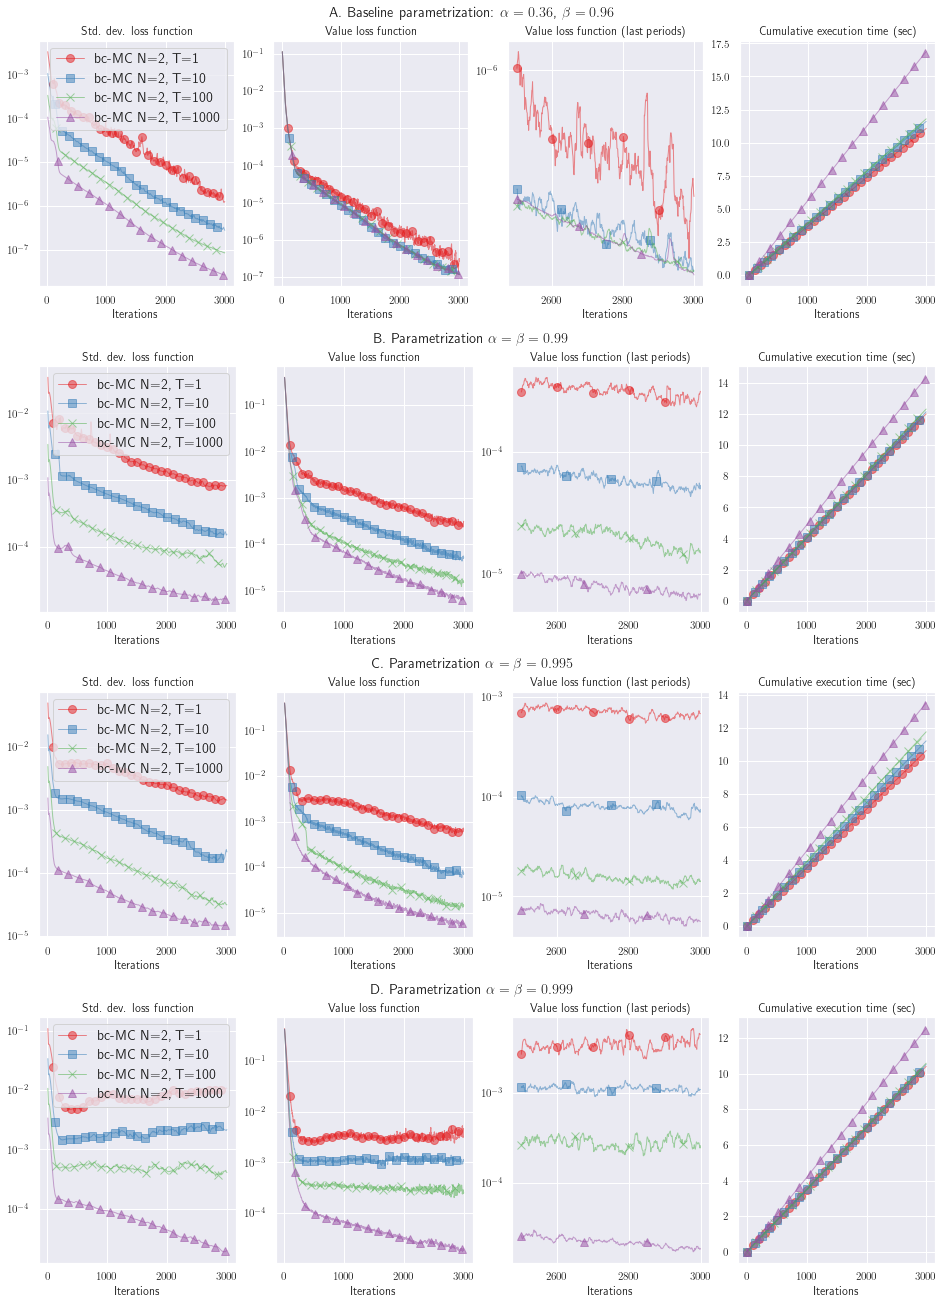

    sigma_e  alpha  beta optim    lr  N     M     T  N_star
8      0.05   0.36  0.96  Adam  0.01  2     1     1   False
9      0.05   0.36  0.96  Adam  0.01  2    10    10   False
10     0.05   0.36  0.96  Adam  0.01  2   100   100   False
11     0.05   0.36  0.96  Adam  0.01  2  1000  1000   False
    sigma_e  alpha  beta optim    lr  N     M     T  N_star
8      0.05   0.99  0.99  Adam  0.01  2     1     1   False
9      0.05   0.99  0.99  Adam  0.01  2    10    10   False
10     0.05   0.99  0.99  Adam  0.01  2   100   100   False
11     0.05   0.99  0.99  Adam  0.01  2  1000  1000   False
    sigma_e  alpha   beta optim    lr  N     M     T  N_star
8      0.05  0.995  0.995  Adam  0.01  2     1     1   False
9      0.05  0.995  0.995  Adam  0.01  2    10    10   False
10     0.05  0.995  0.995  Adam  0.01  2   100   100   False
11     0.05  0.995  0.995  Adam  0.01  2  1000  1000   False
    sigma_e  alpha   beta optim    lr  N     M     T  N_star
8      0.05  0.999  0.999  Adam  0

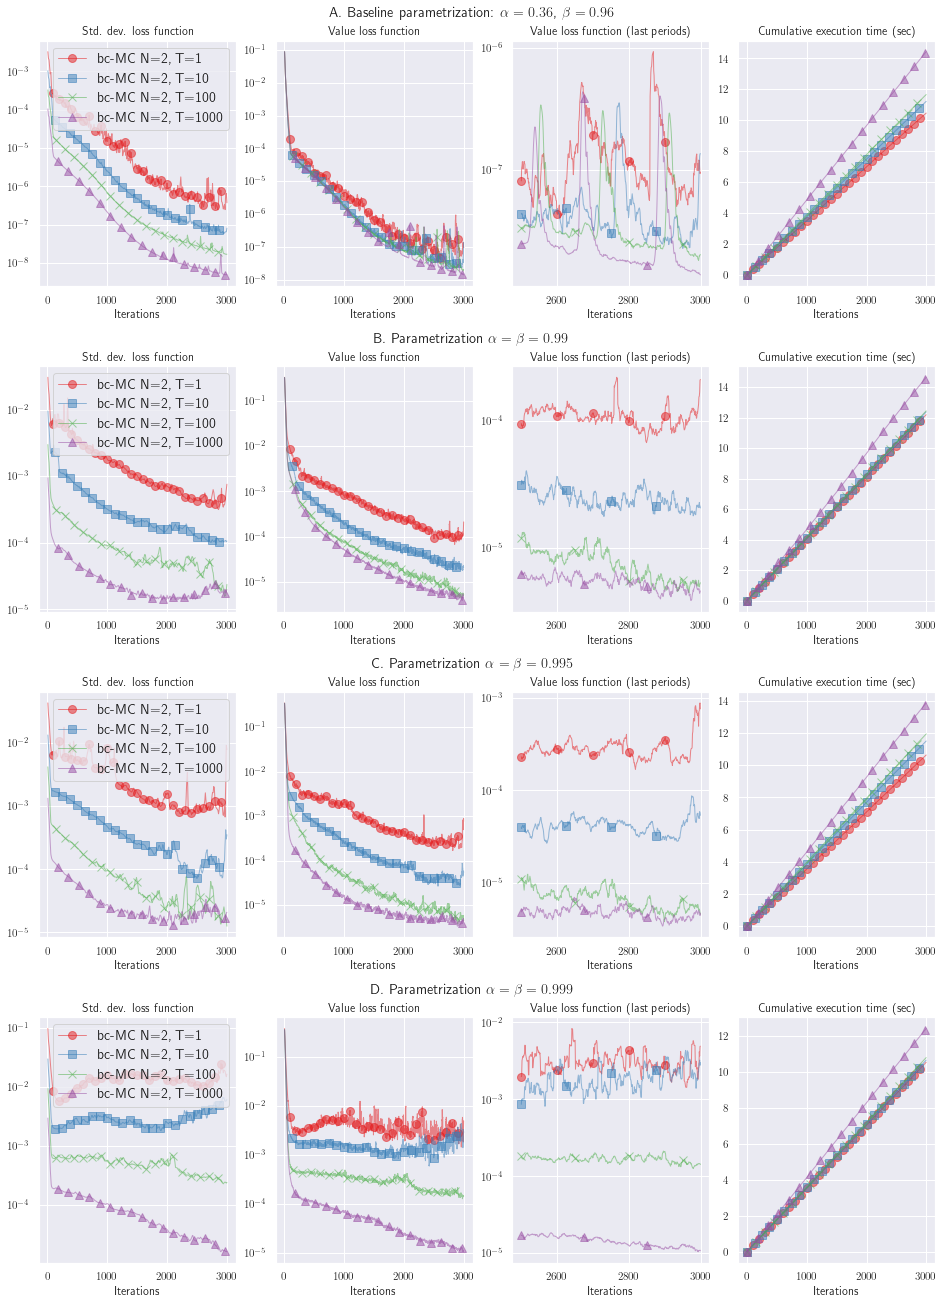

   sigma_e  alpha  beta optim    lr  N     M     T  N_star
4     0.05   0.36  0.96  Adam  0.05  2     1     1   False
5     0.05   0.36  0.96  Adam  0.05  2    10    10   False
6     0.05   0.36  0.96  Adam  0.05  2   100   100   False
7     0.05   0.36  0.96  Adam  0.05  2  1000  1000   False
   sigma_e  alpha  beta optim    lr  N     M     T  N_star
4     0.05   0.99  0.99  Adam  0.05  2     1     1   False
5     0.05   0.99  0.99  Adam  0.05  2    10    10   False
6     0.05   0.99  0.99  Adam  0.05  2   100   100   False
7     0.05   0.99  0.99  Adam  0.05  2  1000  1000   False
   sigma_e  alpha   beta optim    lr  N     M     T  N_star
4     0.05  0.995  0.995  Adam  0.05  2     1     1   False
5     0.05  0.995  0.995  Adam  0.05  2    10    10   False
6     0.05  0.995  0.995  Adam  0.05  2   100   100   False
7     0.05  0.995  0.995  Adam  0.05  2  1000  1000   False
   sigma_e  alpha   beta optim    lr  N     M     T  N_star
4     0.05  0.999  0.999  Adam  0.05  2     1     

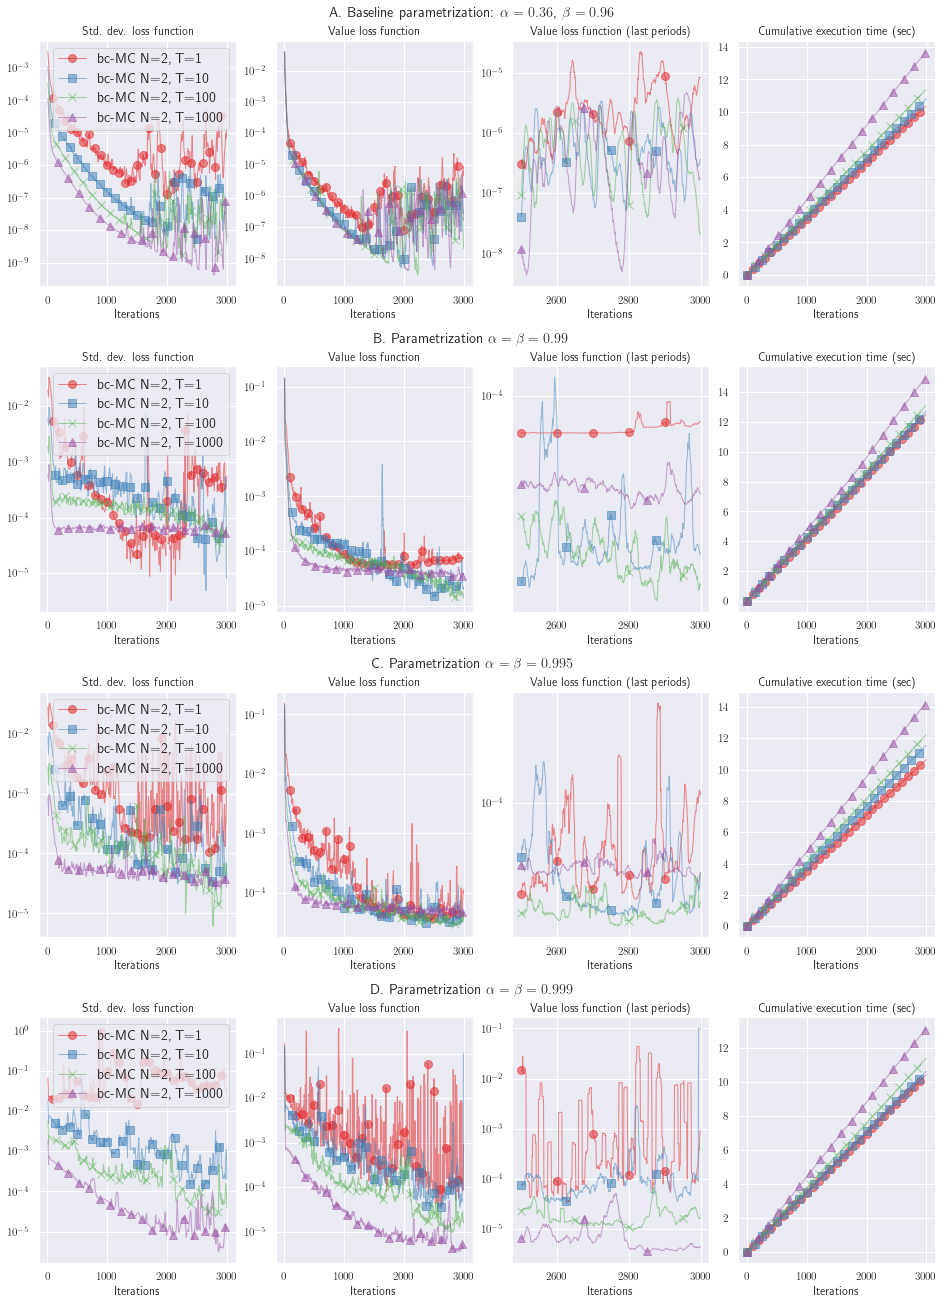

   sigma_e  alpha  beta optim   lr  N     M     T  N_star
0     0.05   0.36  0.96  Adam  0.1  2     1     1   False
1     0.05   0.36  0.96  Adam  0.1  2    10    10   False
2     0.05   0.36  0.96  Adam  0.1  2   100   100   False
3     0.05   0.36  0.96  Adam  0.1  2  1000  1000   False
   sigma_e  alpha  beta optim   lr  N     M     T  N_star
0     0.05   0.99  0.99  Adam  0.1  2     1     1   False
1     0.05   0.99  0.99  Adam  0.1  2    10    10   False
2     0.05   0.99  0.99  Adam  0.1  2   100   100   False
3     0.05   0.99  0.99  Adam  0.1  2  1000  1000   False
   sigma_e  alpha   beta optim   lr  N     M     T  N_star
0     0.05  0.995  0.995  Adam  0.1  2     1     1   False
1     0.05  0.995  0.995  Adam  0.1  2    10    10   False
2     0.05  0.995  0.995  Adam  0.1  2   100   100   False
3     0.05  0.995  0.995  Adam  0.1  2  1000  1000   False
   sigma_e  alpha   beta optim   lr  N     M     T  N_star
0     0.05  0.999  0.999  Adam  0.1  2     1     1   False
1     0

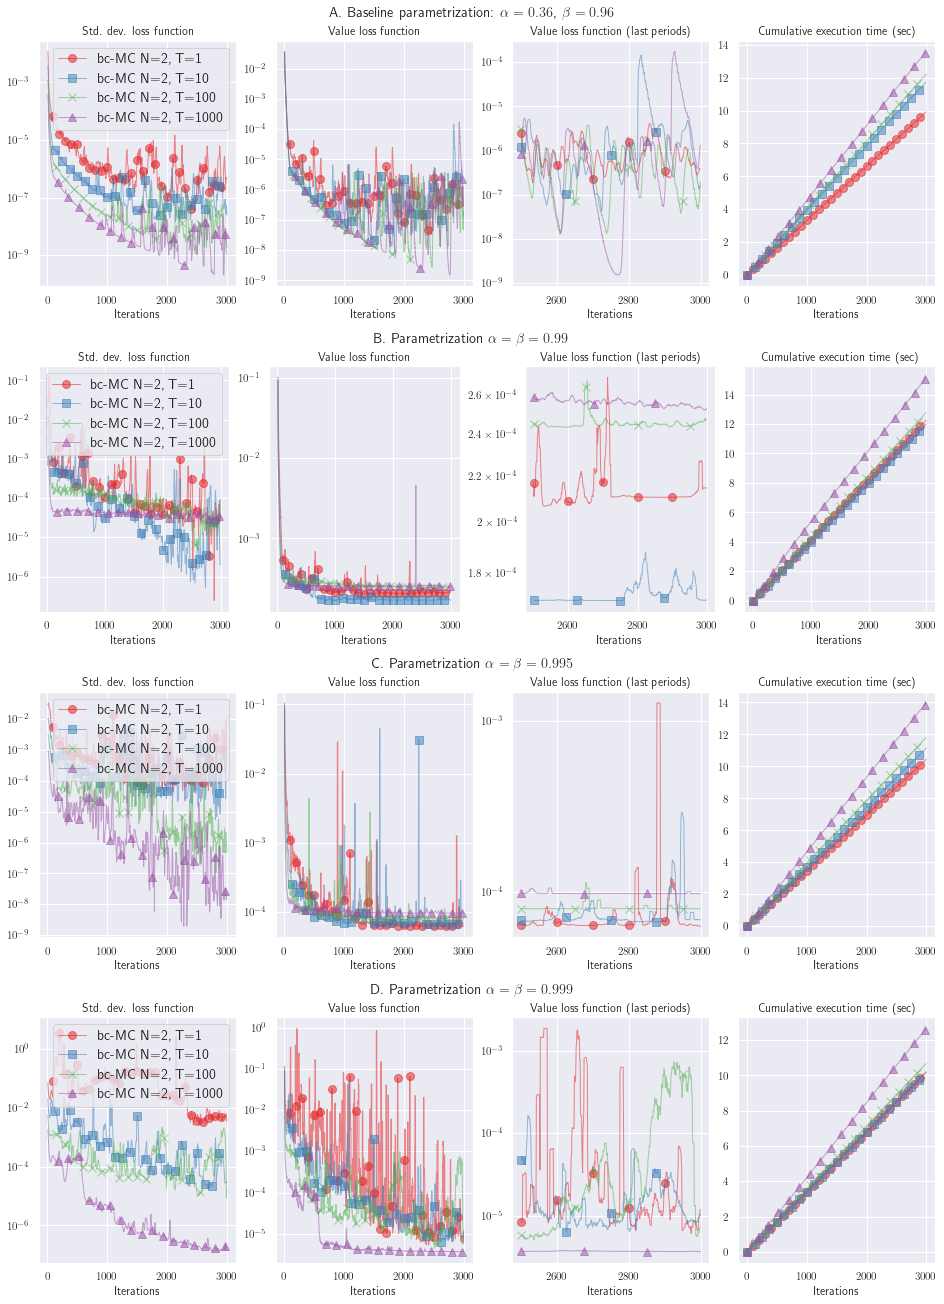

    sigma_e  alpha  beta optim    lr  N     M     T  N_star
12     0.05   0.36  0.96   SGD  0.01  2     1     1   False
13     0.05   0.36  0.96   SGD  0.01  2    10    10   False
14     0.05   0.36  0.96   SGD  0.01  2   100   100   False
15     0.05   0.36  0.96   SGD  0.01  2  1000  1000   False
    sigma_e  alpha  beta optim    lr  N     M     T  N_star
12     0.05   0.99  0.99   SGD  0.01  2     1     1   False
13     0.05   0.99  0.99   SGD  0.01  2    10    10   False
14     0.05   0.99  0.99   SGD  0.01  2   100   100   False
15     0.05   0.99  0.99   SGD  0.01  2  1000  1000   False
    sigma_e  alpha   beta optim    lr  N     M     T  N_star
12     0.05  0.995  0.995   SGD  0.01  2     1     1   False
13     0.05  0.995  0.995   SGD  0.01  2    10    10   False
14     0.05  0.995  0.995   SGD  0.01  2   100   100   False
15     0.05  0.995  0.995   SGD  0.01  2  1000  1000   False
    sigma_e  alpha   beta optim    lr  N     M     T  N_star
12     0.05  0.999  0.999   SGD  0

<Figure size 936x1296 with 0 Axes>

<Figure size 936x1296 with 0 Axes>

<Figure size 936x1296 with 0 Axes>

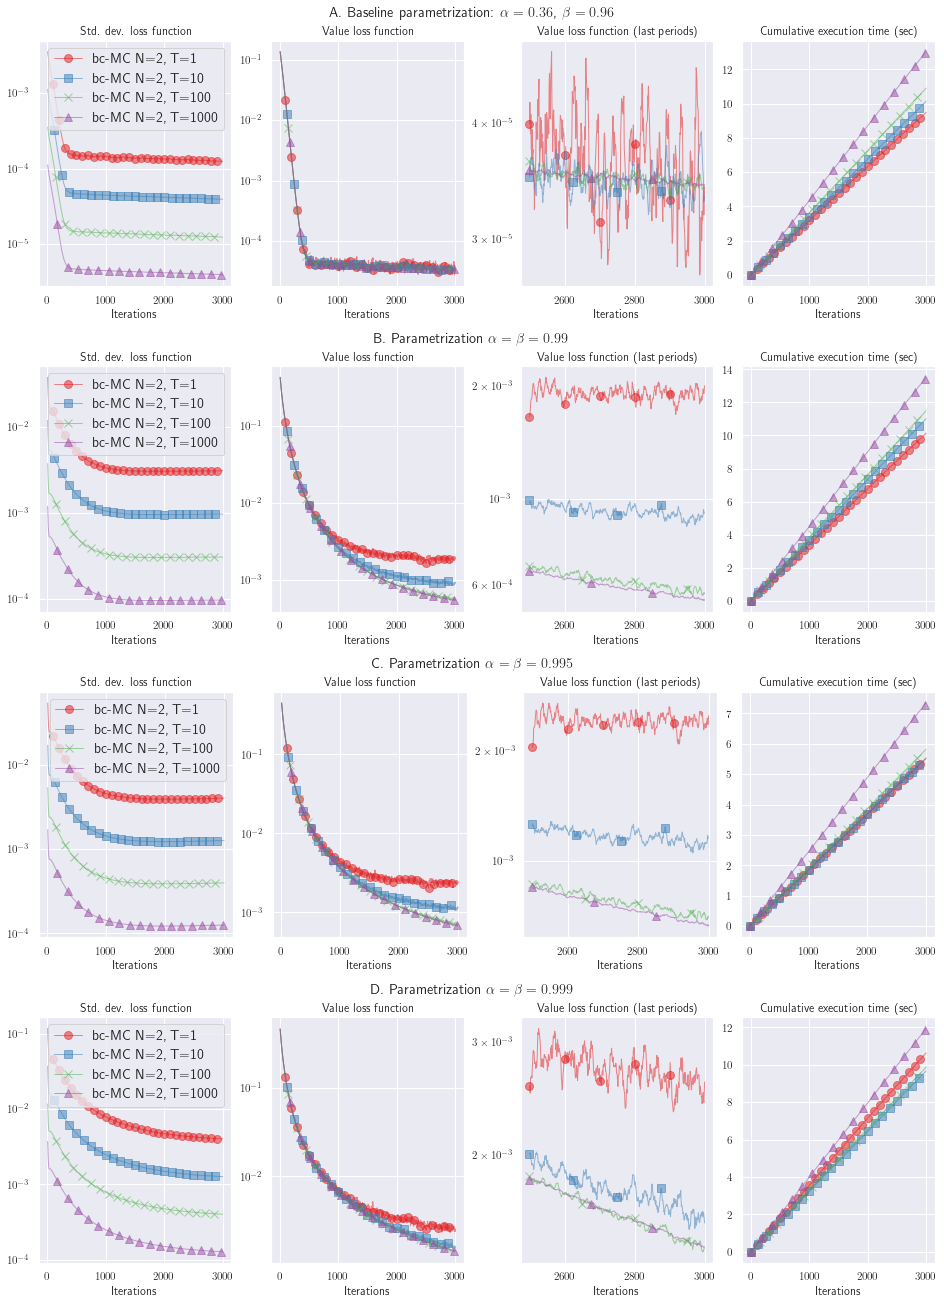

    sigma_e  alpha  beta optim   lr  N     M     T  N_star
8      0.05   0.36  0.96   SGD  0.1  2     1     1   False
9      0.05   0.36  0.96   SGD  0.1  2    10    10   False
10     0.05   0.36  0.96   SGD  0.1  2   100   100   False
11     0.05   0.36  0.96   SGD  0.1  2  1000  1000   False
    sigma_e  alpha  beta optim   lr  N     M     T  N_star
8      0.05   0.99  0.99   SGD  0.1  2     1     1   False
9      0.05   0.99  0.99   SGD  0.1  2    10    10   False
10     0.05   0.99  0.99   SGD  0.1  2   100   100   False
11     0.05   0.99  0.99   SGD  0.1  2  1000  1000   False
    sigma_e  alpha   beta optim   lr  N     M     T  N_star
8      0.05  0.995  0.995   SGD  0.1  2     1     1   False
9      0.05  0.995  0.995   SGD  0.1  2    10    10   False
10     0.05  0.995  0.995   SGD  0.1  2   100   100   False
11     0.05  0.995  0.995   SGD  0.1  2  1000  1000   False
    sigma_e  alpha   beta optim   lr  N     M     T  N_star
8      0.05  0.999  0.999   SGD  0.1  2     1     

<Figure size 936x1296 with 0 Axes>

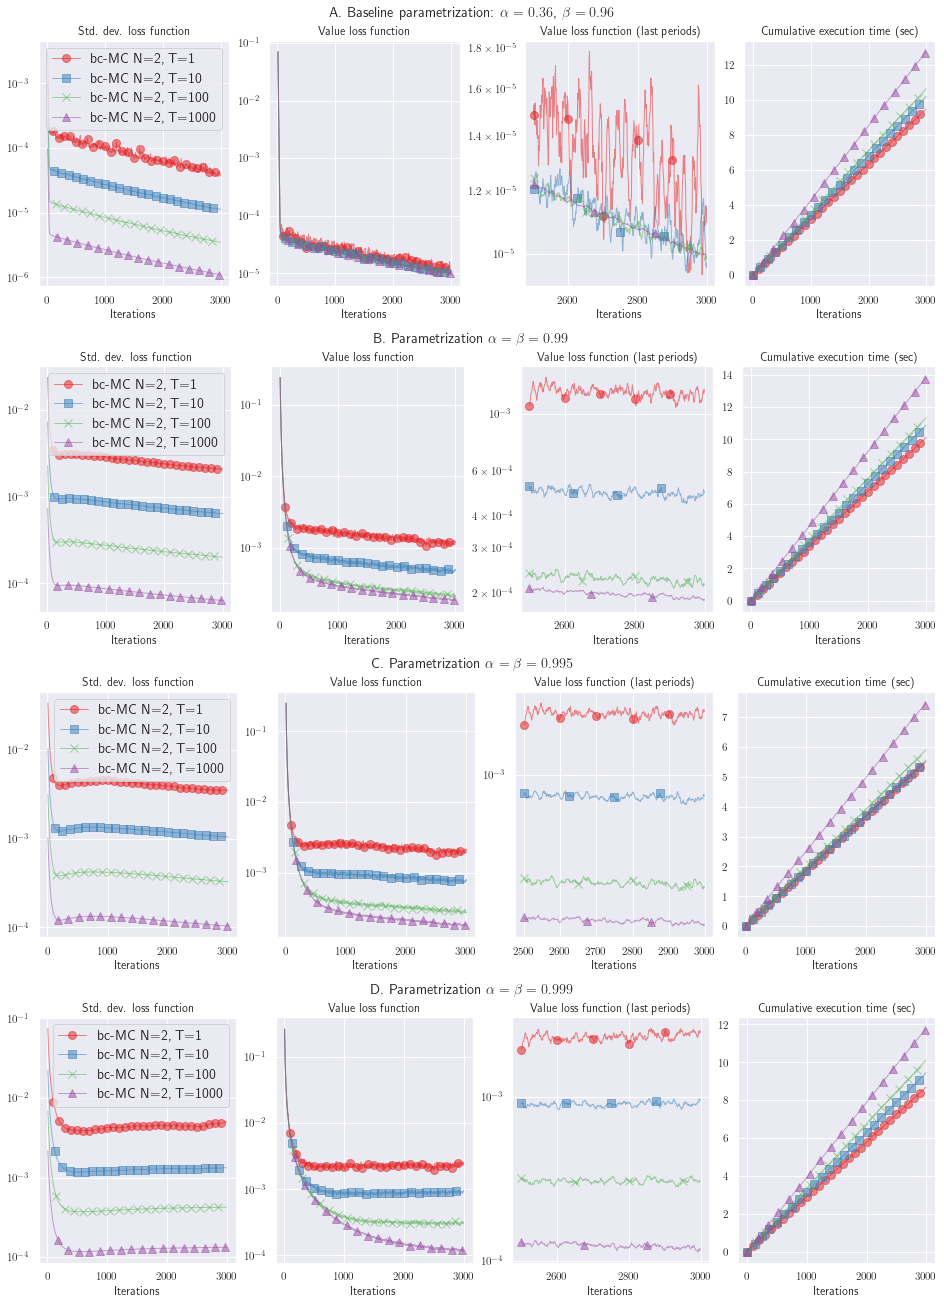

   sigma_e  alpha  beta optim   lr  N     M     T  N_star
4     0.05   0.36  0.96   SGD  1.0  2     1     1   False
5     0.05   0.36  0.96   SGD  1.0  2    10    10   False
6     0.05   0.36  0.96   SGD  1.0  2   100   100   False
7     0.05   0.36  0.96   SGD  1.0  2  1000  1000   False
   sigma_e  alpha  beta optim   lr  N     M     T  N_star
4     0.05   0.99  0.99   SGD  1.0  2     1     1   False
5     0.05   0.99  0.99   SGD  1.0  2    10    10   False
6     0.05   0.99  0.99   SGD  1.0  2   100   100   False
7     0.05   0.99  0.99   SGD  1.0  2  1000  1000   False
   sigma_e  alpha   beta optim   lr  N     M     T  N_star
4     0.05  0.995  0.995   SGD  1.0  2     1     1   False
5     0.05  0.995  0.995   SGD  1.0  2    10    10   False
6     0.05  0.995  0.995   SGD  1.0  2   100   100   False
7     0.05  0.995  0.995   SGD  1.0  2  1000  1000   False
   sigma_e  alpha   beta optim   lr  N     M     T  N_star
4     0.05  0.999  0.999   SGD  1.0  2     1     1   False
5     0

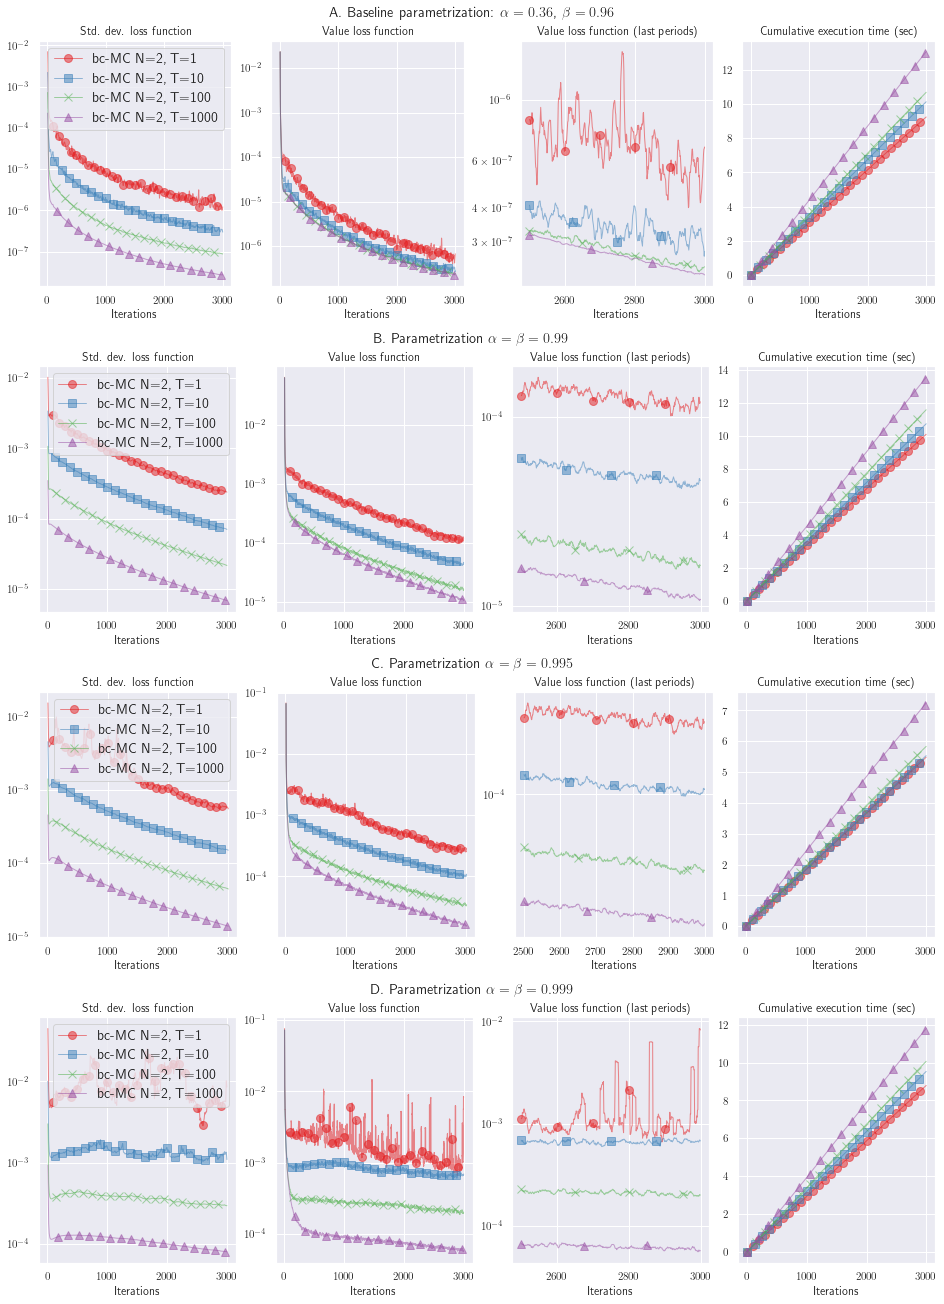

   sigma_e  alpha  beta optim   lr  N     M     T  N_star
0     0.05   0.36  0.96   SGD  2.0  2     1     1   False
1     0.05   0.36  0.96   SGD  2.0  2    10    10   False
2     0.05   0.36  0.96   SGD  2.0  2   100   100   False
3     0.05   0.36  0.96   SGD  2.0  2  1000  1000   False
   sigma_e  alpha  beta optim   lr  N     M     T  N_star
0     0.05   0.99  0.99   SGD  2.0  2     1     1   False
1     0.05   0.99  0.99   SGD  2.0  2    10    10   False
2     0.05   0.99  0.99   SGD  2.0  2   100   100   False
3     0.05   0.99  0.99   SGD  2.0  2  1000  1000   False
   sigma_e  alpha   beta optim   lr  N     M     T  N_star
0     0.05  0.995  0.995   SGD  2.0  2     1     1   False
1     0.05  0.995  0.995   SGD  2.0  2    10    10   False
2     0.05  0.995  0.995   SGD  2.0  2   100   100   False
3     0.05  0.995  0.995   SGD  2.0  2  1000  1000   False
   sigma_e  alpha   beta optim   lr  N     M     T  N_star
0     0.05  0.999  0.999   SGD  2.0  2     1     1   False
1     0

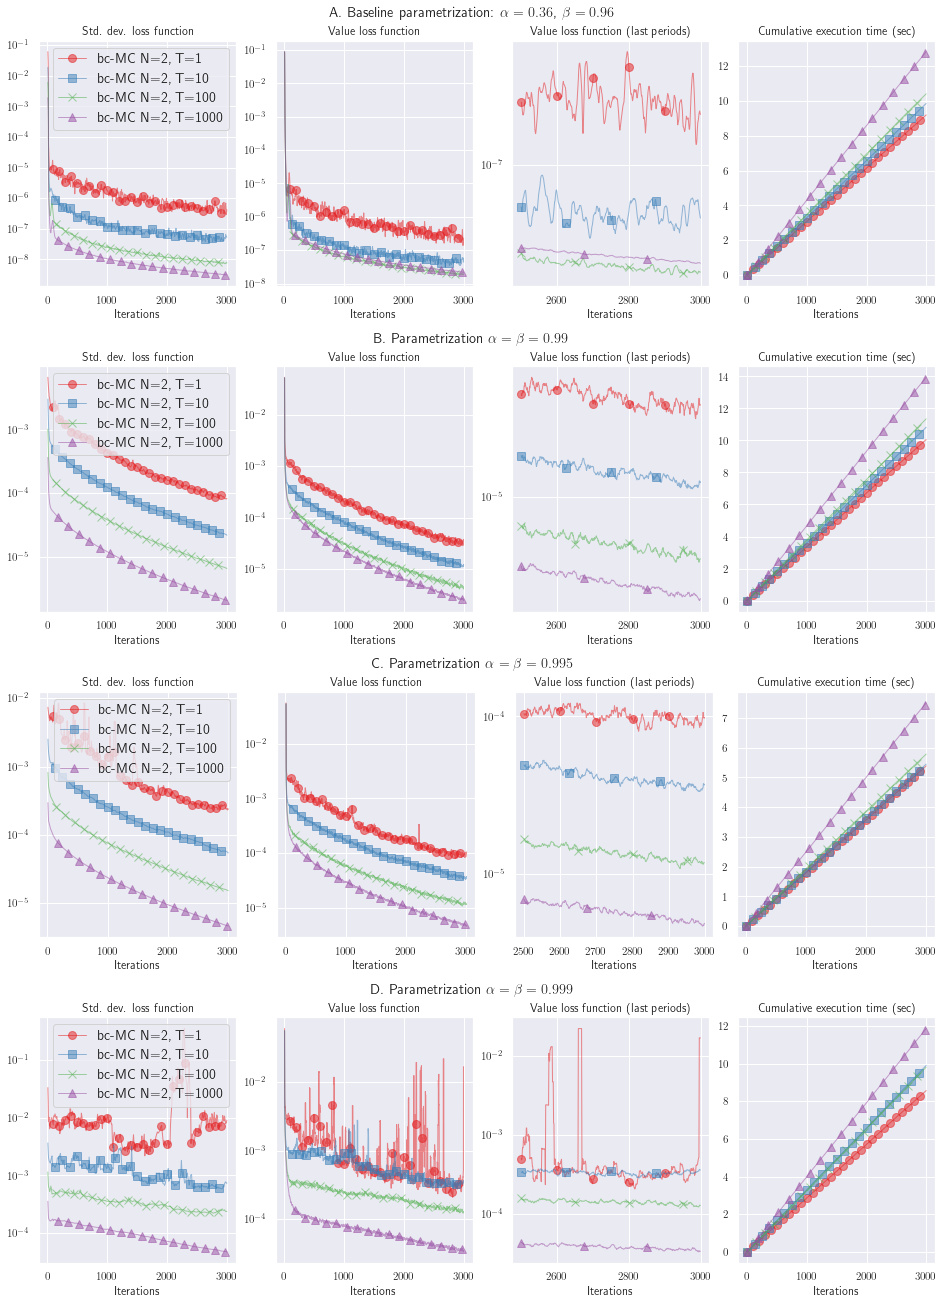

In [12]:
# One page plot, with zonn             
mult = 2
#Read all hyperparameters
extension_csv_file = "changing_M"
create_zoom = True #add a zoom on the last periods of losses
list_lr = []
list_optim = []
for nb in range(min_nb_plot, max_nb_plot):
    output_extension = f"BM_{nb}"
    local_path = os.getcwd() + f'/{output_extension}/file/content/output/{output_extension}/'
    df_hyperparams = pd.read_csv(local_path  + f'hyperparams_{extension_csv_file}.csv')
    list_lr.append(list(np.unique(df_hyperparams['lr'])))
    list_optim.append(list(np.unique(df_hyperparams['optim'])))
# make unique
list_lr = np.unique(list_lr)
list_optim = np.unique(list_optim)

# Define your subtitles
row_titles = [r'A. Baseline parametrization: $\alpha = 0.36$, $\beta = 0.96$', 
              r'B. Parametrization $\alpha = \beta = 0.99 $', 
              r'C. Parametrization $\alpha = \beta = 0.995 $', 
              r'D. Parametrization $\alpha = \beta = 0.999 $']

for optim_selected in list_optim:
    for lr_selected in list_lr: 
        plot_nb = -1 #initialization
        #fig, axs = plt.subplots(4, 4, figsize=(mult*6.5, mult*9)) #Single plot
        fig = plt.figure(constrained_layout=True, figsize=(mult*6.5, mult*9))
        (subfig0, subfig1, subfig2, subfig3) = fig.subfigures(4, 1) # create 4x1 subfigures
        
        graph_empty=True
        for nb in range(min_nb_plot, max_nb_plot):
            output_extension = f"BM_{nb}"
            output_folder = current_wd  + f"/output/{output_extension}/"

            # Load files
            extension_csv_file = "changing_M"
            local_path = os.getcwd() + f'/{output_extension}/file/content/output/{output_extension}/'

            # LOAD DATA
            if read_from_csv == True:
                #print("Reading CSV")
                df_hyperparams = pd.read_csv(local_path  + f'hyperparams_{extension_csv_file}.csv')
                #print(df_hyperparams)

                list_dfs_hyperparams = []
                for index, row in df_hyperparams.iterrows():
                    σ_e_chosen = row['sigma_e']
                    α_chosen = row['alpha']
                    β_chosen = row['beta']
                    optimizer_chosen = row["optim"]
                    lr_chosen = row["lr"]
                    N_chosen = row["N"]
                    M_chosen = row["M"]
                    use_N_star = row["N_star"]
                    # Save to disk
                    filen = local_path + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_σ_{σ_e_chosen}_α_{α_chosen}.csv'
                    list_dfs_hyperparams.append(pd.read_csv(filen))


            list_combinations_used = []
            for index, row in df_hyperparams.iterrows():
                σ_e_chosen = row['sigma_e']
                α_chosen = row['alpha']
                β_chosen = row['beta']
                optimizer_chosen = row["optim"]
                lr_chosen = row["lr"]
                N_chosen = row["N"]
                M_chosen = row["M"]
                use_N_star = row["N_star"]

                combination = f'{optimizer_chosen}-{σ_e_chosen}-{α_chosen}-{β_chosen}-{lr_chosen}'
                if combination not in list_combinations_used:
                    list_combinations_used.append(combination)
                else:
                    continue #If combination already used, pass

                # Pass if lr
                if (lr_chosen != lr_selected) | (optimizer_chosen != optim_selected):
                    continue
                else: 
                    graph_empty = False
                    plot_nb+=1
                    if plot_nb>3:
                        break

                df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
                df_sel = df_sel[df_sel["sigma_e"] == σ_e_chosen]
                df_sel = df_sel[df_sel["alpha"] == α_chosen]
                df_sel = df_sel[df_sel["beta"] == β_chosen]
                df_sel = df_sel[df_sel["lr"] == lr_chosen]
                print(df_sel)


                list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
                list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
                list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
                list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
                list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

                list_labels = []
                for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                    if N_star == True:
                        list_labels += [f"bc-MC N*, T={T}"]
                    else:
                        list_labels += [f"bc-MC N={N}, T={T}"]
                #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

                if create_zoom == False:
                    (ax2, ax3, ax5) =  eval(f"subfig{plot_nb}.subplots(1, 3)")
                else:
                    (ax2, ax3, ax4, ax5) =  eval(f"subfig{plot_nb}.subplots(1, 4)")
                    
                eval(f"subfig{plot_nb}.suptitle(row_titles[{plot_nb}])")

                #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
                for (i, (min_index, max_index)) in enumerate(zip([0], [3000])):
                    #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
                    #fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4)
                    #fig, (ax2, ax3, ax5) = plt.subplots(1, 3)

                    """
                    var = "optimal_N"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    #ax1.set_yscale('log')
                    ax1.set_title('Value for N')
                    ax1.set_xlabel("Iterations")
                    """

                    var = "var_loss"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                    ax2.set_yscale('log')
                    ax2.set_title('Std. dev. loss function')
                    ax2.legend(loc="upper right")
                    ax2.set_xlabel("Iterations")

                    var = "loss"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                    ax3.set_yscale('log')
                    ax3.set_title('Value loss function')
                    ax3.set_xlabel("Iterations")

                    if create_zoom == True:
                        min_index_local = 2500 #1500 
                        max_index_local = 3000 #2000
                        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                            ax4.plot(df["iter"][min_index_local:max_index_local], MA_series[min_index_local:max_index_local], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                            if display_CI==True:
                                ax4.fill_between(df["iter"][min_index_local:max_index_local], MA_series[min_index_local:max_index_local] - mult*MA_std[min_index_local:max_index_local], MA_series[min_index_local:max_index_local] + mult*MA_std[min_index_local:max_index_local], color=c, alpha=alpha_bands)
                        ax4.set_yscale('log')
                        #ax3.set_xscale('log')
                        ax4.set_title('Value loss function (last periods)')
                        ax4.set_xlabel("Iterations")
                    
                    var = "time"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

                    ax5.set_xlabel("Iterations")
                    ax5.set_title("Cumulative execution time (sec)")

        if graph_empty == False:
            figname = os.getcwd() + f'/output/{extension_csv_file}_lr_{lr_selected}_optim_{optim_selected}_one_page_zoom_{create_zoom}.png'
            plt.savefig(figname, bbox_inches="tight", dpi=300)

            figname = os.getcwd() + f'/output/{extension_csv_file}_lr_{lr_selected}_optim_{optim_selected}_one_page_zoom_{create_zoom}.pdf'
            plt.savefig(figname, bbox_inches="tight", dpi=600)
            plt.show()

### B. Vary M and N and test optimal N*

In [13]:
extension_csv_file = "opt_N"
create_small_plots = False

if create_small_plots == True:
    for nb in range(min_nb_plot, max_nb_plot):
        output_extension = f"BM_{nb}"
        output_folder = current_wd  + f"/output/{output_extension}/"

        # Load files
        extension_csv_file = "opt_N"
        local_path = os.getcwd() + f'/{output_extension}/file/content/output/{output_extension}/'

        if read_from_csv == True:
            #print("Reading CSV")

            df_hyperparams = pd.read_csv(local_path  + f'hyperparams_{extension_csv_file}.csv')
            #print(df_hyperparams)

            list_dfs_hyperparams = []
            for index, row in df_hyperparams.iterrows():
                σ_e_chosen = row['sigma_e']
                α_chosen = row['alpha']
                β_chosen = row['beta']
                optimizer_chosen = row["optim"]
                lr_chosen = row["lr"]
                N_chosen = row["N"]
                M_chosen = row["M"]
                use_N_star = row["N_star"]
                # Save to disk
                filen = local_path + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_σ_{σ_e_chosen}_α_{α_chosen}.csv'
                list_dfs_hyperparams.append(pd.read_csv(filen))


        list_combinations_used = []
        for index, row in df_hyperparams.iterrows():
            σ_e_chosen = row['sigma_e']
            α_chosen = row['alpha']
            β_chosen = row['beta']
            optimizer_chosen = row["optim"]
            lr_chosen = row["lr"]
            N_chosen = row["N"]
            M_chosen = row["M"]
            use_N_star = row["N_star"]

            combination = f'{optimizer_chosen}-{σ_e_chosen}-{α_chosen}-{β_chosen}-{lr_chosen}'
            if combination not in list_combinations_used:
                list_combinations_used.append(combination)
            else:
                continue #If combination already used, pass
            df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
            df_sel = df_sel[df_sel["sigma_e"] == σ_e_chosen]
            df_sel = df_sel[df_sel["alpha"] == α_chosen]
            df_sel = df_sel[df_sel["beta"] == β_chosen]
            df_sel = df_sel[df_sel["lr"] == lr_chosen]
            print(df_sel)


            list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
            list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
            list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
            list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
            list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

            list_labels = []
            for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                if N_star == True:
                    list_labels += [f"bc-MC N*, T={T}"]
                else:
                    list_labels += [f"bc-MC N={N}, T={T}"]
            #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

            #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
            for (i, (min_index, max_index)) in enumerate(zip([0], [3000])):
                #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
                fig, (ax1, ax2, ax3, ax5) = plt.subplots(1, 4)

                var = "optimal_N"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                #ax1.set_yscale('log')
                ax1.set_title('Value for N')
                ax1.set_xlabel("Iterations")

                var = "var_loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                ax2.set_yscale('log')
                ax2.set_title('Std. dev. loss function')
                ax2.legend(loc="upper right")
                ax2.set_xlabel("Iterations")

                var = "loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                ax3.set_yscale('log')
                ax3.set_title('Value loss function')
                ax3.set_xlabel("Iterations")


                """
                #var = "mean_percentage_error"
                var = "mean_Euler_error"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                """

                # Redundant with loss
                """
                # square root series for loss
                var = "loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = np.sqrt(pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean()) # Moving average series
                    MA_std = np.sqrt(pd.Series(df[f"std_{var}"]).rolling(rate).mean()) # Moving average std dev. across series, for same hyperparams
                    ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)

                ax4.set_yscale('log')
                ax4.set_title('Mean Euler equation error')
                ax4.set_xlabel("Iterations")
                """

                var = "time"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

                ax5.set_xlabel("Iterations")
                ax5.set_title("Cumulative execution time (sec)")

                figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.png'
                plt.savefig(figname, bbox_inches="tight", dpi=300)

                figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.pdf'
                plt.savefig(figname, bbox_inches="tight", dpi=300)
                plt.show()


### Create a one-page plots

    sigma_e  alpha  beta optim     lr    N    M    T  N_star
12     0.05   0.36  0.96  Adam  0.005    2  100  100    True
13     0.05   0.36  0.96  Adam  0.005  100    2  100   False
14     0.05   0.36  0.96  Adam  0.005   20   10  100   False
15     0.05   0.36  0.96  Adam  0.005    2  100  100   False
    sigma_e  alpha  beta optim     lr    N    M    T  N_star
12     0.05   0.99  0.99  Adam  0.005    2  100  100    True
13     0.05   0.99  0.99  Adam  0.005  100    2  100   False
14     0.05   0.99  0.99  Adam  0.005   20   10  100   False
15     0.05   0.99  0.99  Adam  0.005    2  100  100   False
    sigma_e  alpha   beta optim     lr    N    M    T  N_star
12     0.05  0.995  0.995  Adam  0.005    2  100  100    True
13     0.05  0.995  0.995  Adam  0.005  100    2  100   False
14     0.05  0.995  0.995  Adam  0.005   20   10  100   False
15     0.05  0.995  0.995  Adam  0.005    2  100  100   False
    sigma_e  alpha   beta optim     lr    N    M    T  N_star
12     0.05  0.999

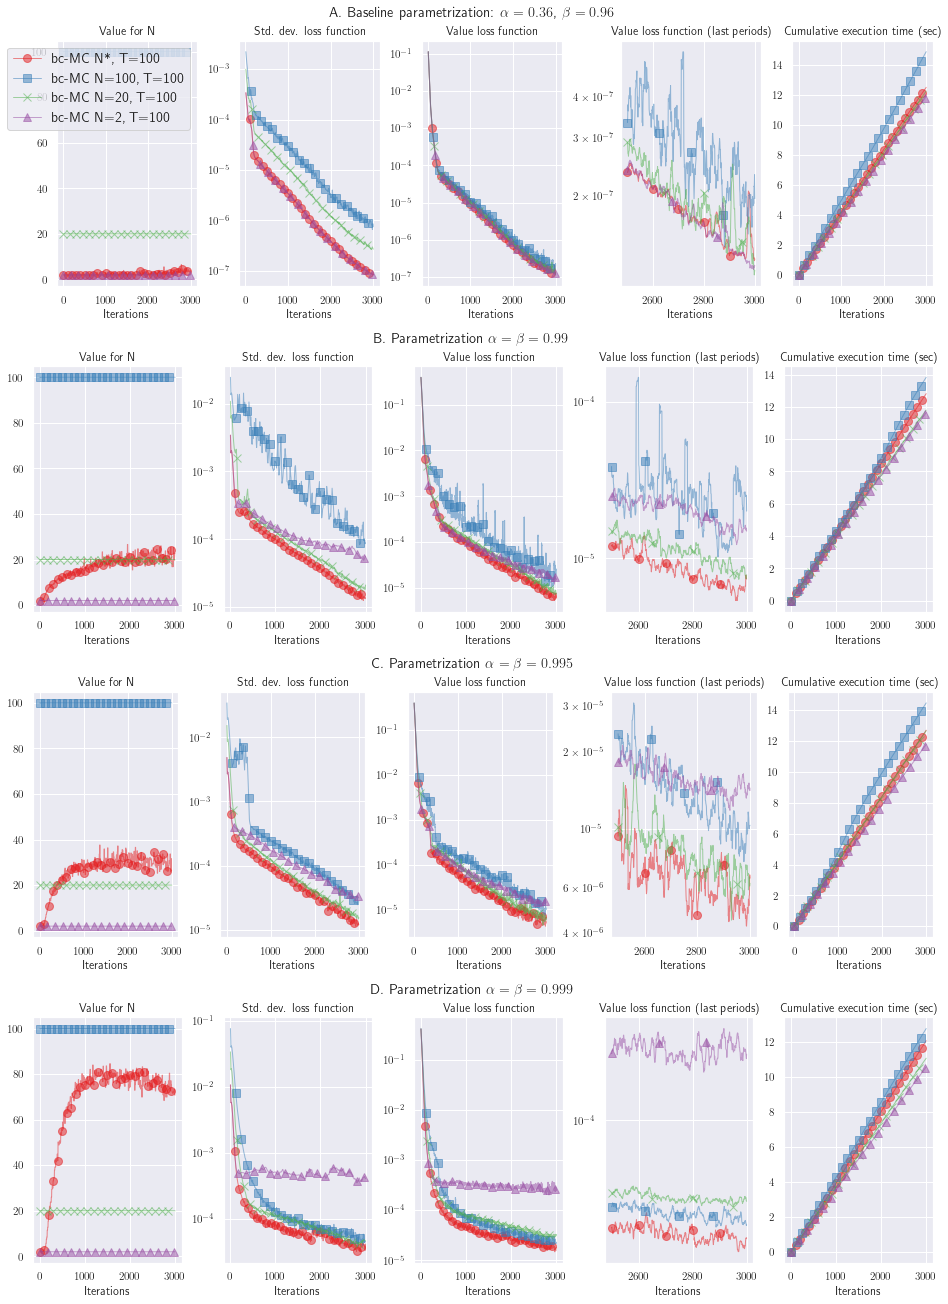

    sigma_e  alpha  beta optim    lr    N    M    T  N_star
8      0.05   0.36  0.96  Adam  0.01    2  100  100    True
9      0.05   0.36  0.96  Adam  0.01  100    2  100   False
10     0.05   0.36  0.96  Adam  0.01   20   10  100   False
11     0.05   0.36  0.96  Adam  0.01    2  100  100   False
    sigma_e  alpha  beta optim    lr    N    M    T  N_star
8      0.05   0.99  0.99  Adam  0.01    2  100  100    True
9      0.05   0.99  0.99  Adam  0.01  100    2  100   False
10     0.05   0.99  0.99  Adam  0.01   20   10  100   False
11     0.05   0.99  0.99  Adam  0.01    2  100  100   False
    sigma_e  alpha   beta optim    lr    N    M    T  N_star
8      0.05  0.995  0.995  Adam  0.01    2  100  100    True
9      0.05  0.995  0.995  Adam  0.01  100    2  100   False
10     0.05  0.995  0.995  Adam  0.01   20   10  100   False
11     0.05  0.995  0.995  Adam  0.01    2  100  100   False
    sigma_e  alpha   beta optim    lr    N    M    T  N_star
8      0.05  0.999  0.999  Adam  0

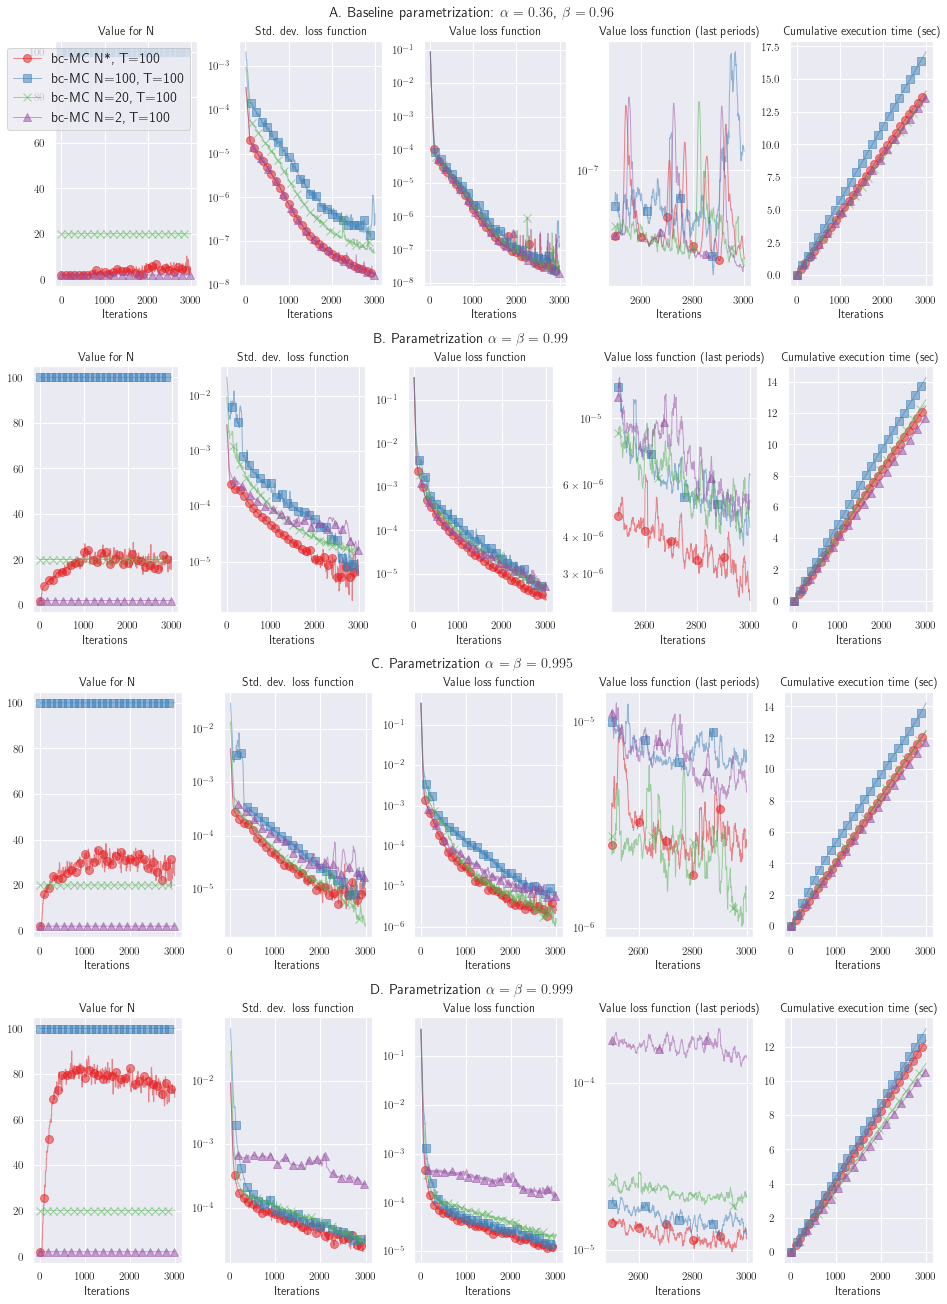

   sigma_e  alpha  beta optim    lr    N    M    T  N_star
4     0.05   0.36  0.96  Adam  0.05    2  100  100    True
5     0.05   0.36  0.96  Adam  0.05  100    2  100   False
6     0.05   0.36  0.96  Adam  0.05   20   10  100   False
7     0.05   0.36  0.96  Adam  0.05    2  100  100   False
   sigma_e  alpha  beta optim    lr    N    M    T  N_star
4     0.05   0.99  0.99  Adam  0.05    2  100  100    True
5     0.05   0.99  0.99  Adam  0.05  100    2  100   False
6     0.05   0.99  0.99  Adam  0.05   20   10  100   False
7     0.05   0.99  0.99  Adam  0.05    2  100  100   False
   sigma_e  alpha   beta optim    lr    N    M    T  N_star
4     0.05  0.995  0.995  Adam  0.05    2  100  100    True
5     0.05  0.995  0.995  Adam  0.05  100    2  100   False
6     0.05  0.995  0.995  Adam  0.05   20   10  100   False
7     0.05  0.995  0.995  Adam  0.05    2  100  100   False
   sigma_e  alpha   beta optim    lr    N    M    T  N_star
4     0.05  0.999  0.999  Adam  0.05    2  100  10

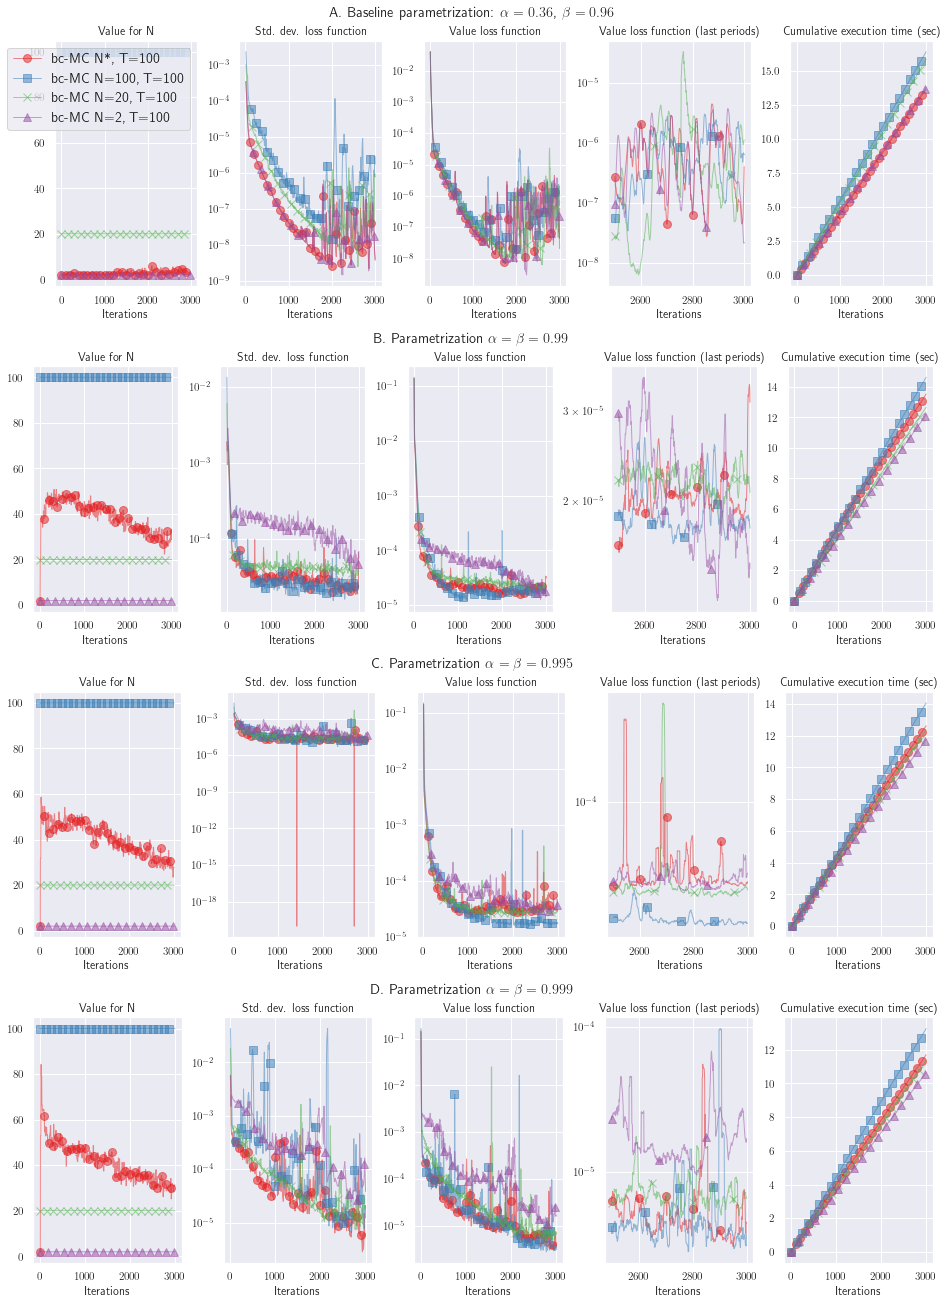

   sigma_e  alpha  beta optim   lr    N    M    T  N_star
0     0.05   0.36  0.96  Adam  0.1    2  100  100    True
1     0.05   0.36  0.96  Adam  0.1  100    2  100   False
2     0.05   0.36  0.96  Adam  0.1   20   10  100   False
3     0.05   0.36  0.96  Adam  0.1    2  100  100   False
   sigma_e  alpha  beta optim   lr    N    M    T  N_star
0     0.05   0.99  0.99  Adam  0.1    2  100  100    True
1     0.05   0.99  0.99  Adam  0.1  100    2  100   False
2     0.05   0.99  0.99  Adam  0.1   20   10  100   False
3     0.05   0.99  0.99  Adam  0.1    2  100  100   False
   sigma_e  alpha   beta optim   lr    N    M    T  N_star
0     0.05  0.995  0.995  Adam  0.1    2  100  100    True
1     0.05  0.995  0.995  Adam  0.1  100    2  100   False
2     0.05  0.995  0.995  Adam  0.1   20   10  100   False
3     0.05  0.995  0.995  Adam  0.1    2  100  100   False
   sigma_e  alpha   beta optim   lr    N    M    T  N_star
0     0.05  0.999  0.999  Adam  0.1    2  100  100    True
1     0

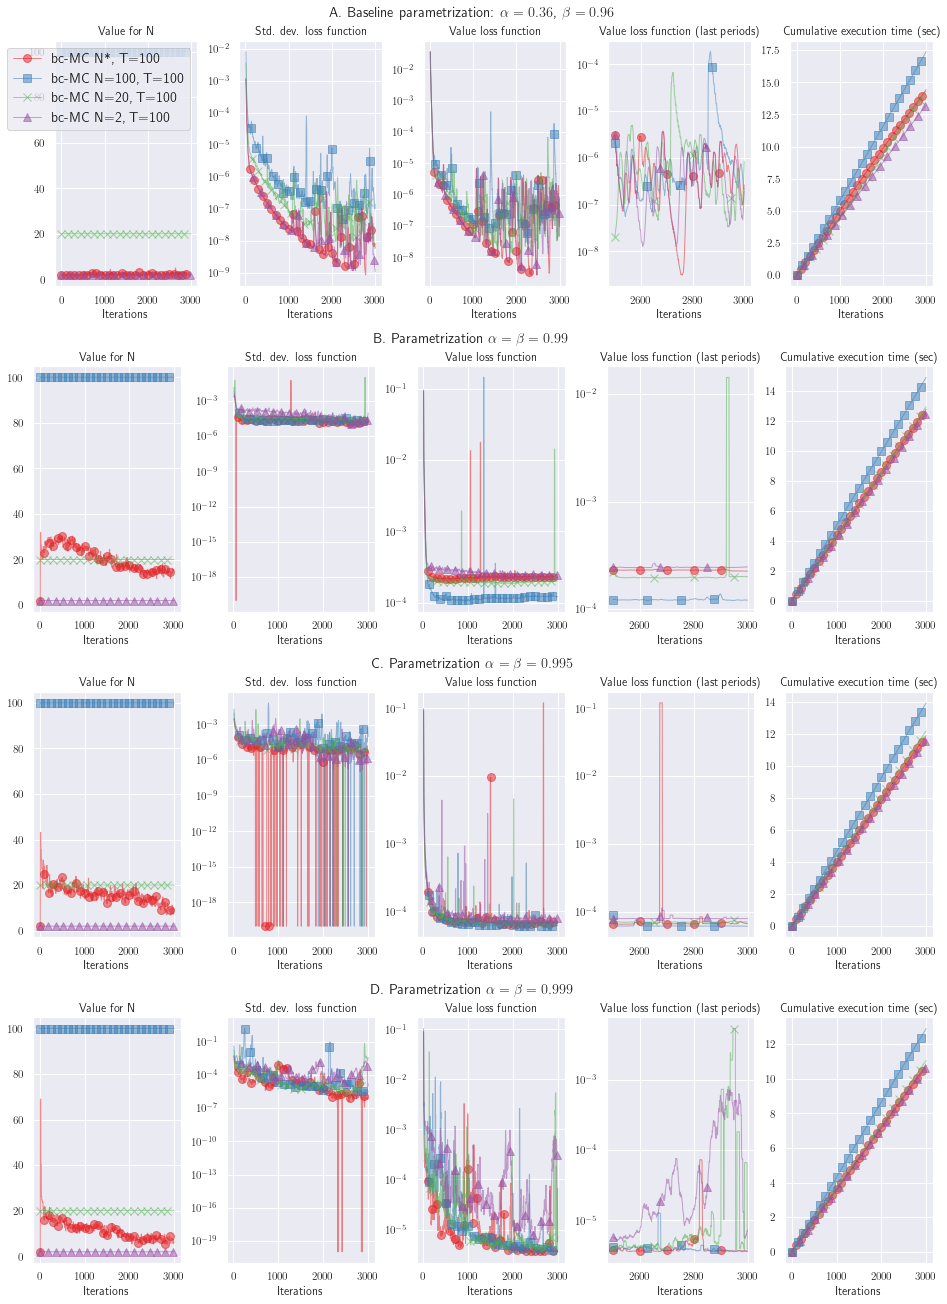

    sigma_e  alpha  beta optim    lr    N    M    T  N_star
12     0.05   0.36  0.96   SGD  0.01    2  100  100    True
13     0.05   0.36  0.96   SGD  0.01  100    2  100   False
14     0.05   0.36  0.96   SGD  0.01   20   10  100   False
15     0.05   0.36  0.96   SGD  0.01    2  100  100   False
    sigma_e  alpha  beta optim    lr    N    M    T  N_star
12     0.05   0.99  0.99   SGD  0.01    2  100  100    True
13     0.05   0.99  0.99   SGD  0.01  100    2  100   False
14     0.05   0.99  0.99   SGD  0.01   20   10  100   False
15     0.05   0.99  0.99   SGD  0.01    2  100  100   False
    sigma_e  alpha   beta optim    lr    N    M    T  N_star
12     0.05  0.995  0.995   SGD  0.01    2  100  100    True
13     0.05  0.995  0.995   SGD  0.01  100    2  100   False
14     0.05  0.995  0.995   SGD  0.01   20   10  100   False
15     0.05  0.995  0.995   SGD  0.01    2  100  100   False
    sigma_e  alpha   beta optim    lr    N    M    T  N_star
12     0.05  0.999  0.999   SGD  0

<Figure size 936x1296 with 0 Axes>

<Figure size 936x1296 with 0 Axes>

<Figure size 936x1296 with 0 Axes>

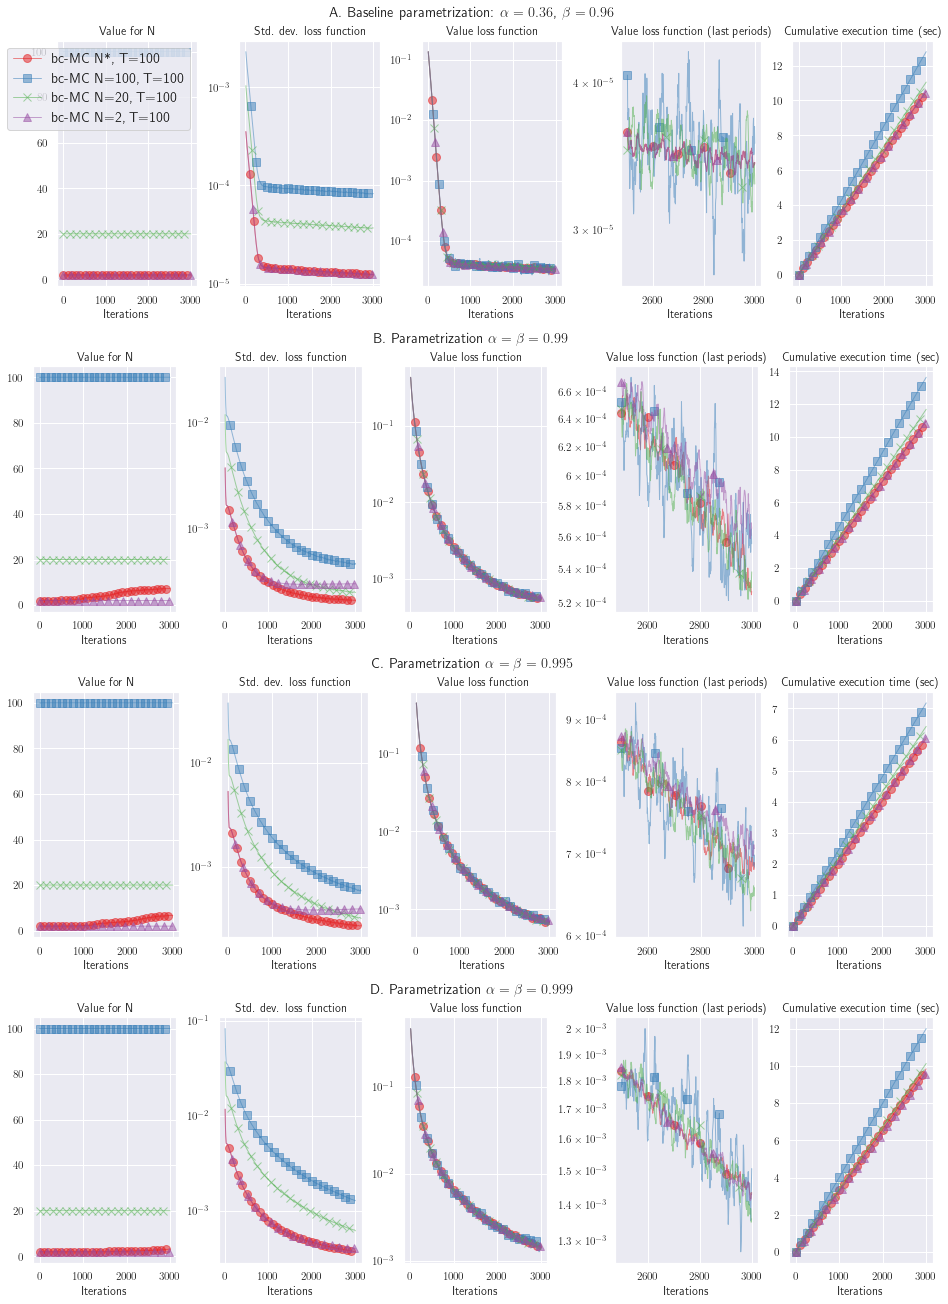

    sigma_e  alpha  beta optim   lr    N    M    T  N_star
8      0.05   0.36  0.96   SGD  0.1    2  100  100    True
9      0.05   0.36  0.96   SGD  0.1  100    2  100   False
10     0.05   0.36  0.96   SGD  0.1   20   10  100   False
11     0.05   0.36  0.96   SGD  0.1    2  100  100   False
    sigma_e  alpha  beta optim   lr    N    M    T  N_star
8      0.05   0.99  0.99   SGD  0.1    2  100  100    True
9      0.05   0.99  0.99   SGD  0.1  100    2  100   False
10     0.05   0.99  0.99   SGD  0.1   20   10  100   False
11     0.05   0.99  0.99   SGD  0.1    2  100  100   False
    sigma_e  alpha   beta optim   lr    N    M    T  N_star
8      0.05  0.995  0.995   SGD  0.1    2  100  100    True
9      0.05  0.995  0.995   SGD  0.1  100    2  100   False
10     0.05  0.995  0.995   SGD  0.1   20   10  100   False
11     0.05  0.995  0.995   SGD  0.1    2  100  100   False
    sigma_e  alpha   beta optim   lr    N    M    T  N_star
8      0.05  0.999  0.999   SGD  0.1    2  100  10

<Figure size 936x1296 with 0 Axes>

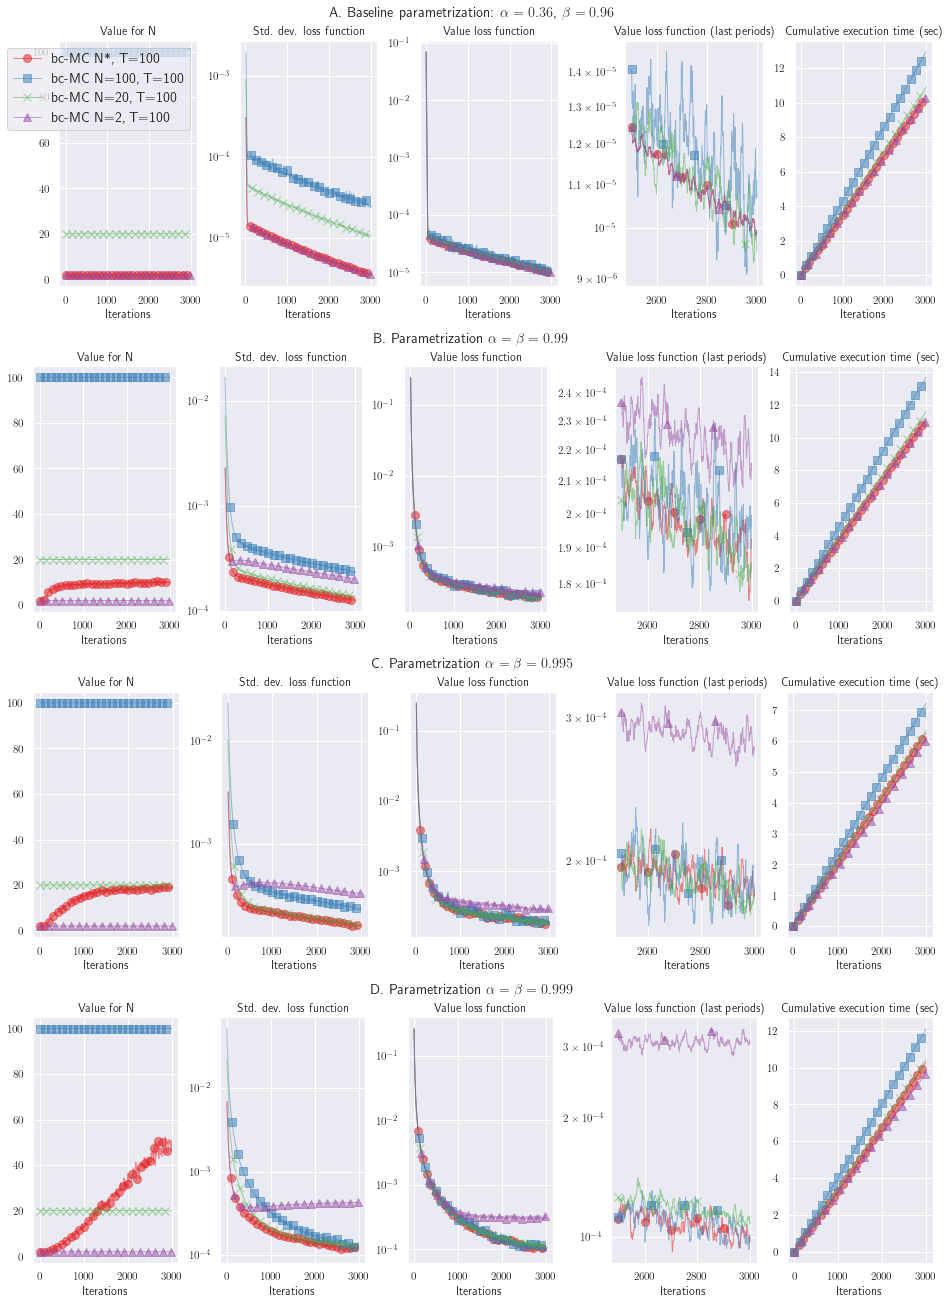

   sigma_e  alpha  beta optim   lr    N    M    T  N_star
4     0.05   0.36  0.96   SGD  1.0    2  100  100    True
5     0.05   0.36  0.96   SGD  1.0  100    2  100   False
6     0.05   0.36  0.96   SGD  1.0   20   10  100   False
7     0.05   0.36  0.96   SGD  1.0    2  100  100   False
   sigma_e  alpha  beta optim   lr    N    M    T  N_star
4     0.05   0.99  0.99   SGD  1.0    2  100  100    True
5     0.05   0.99  0.99   SGD  1.0  100    2  100   False
6     0.05   0.99  0.99   SGD  1.0   20   10  100   False
7     0.05   0.99  0.99   SGD  1.0    2  100  100   False
   sigma_e  alpha   beta optim   lr    N    M    T  N_star
4     0.05  0.995  0.995   SGD  1.0    2  100  100    True
5     0.05  0.995  0.995   SGD  1.0  100    2  100   False
6     0.05  0.995  0.995   SGD  1.0   20   10  100   False
7     0.05  0.995  0.995   SGD  1.0    2  100  100   False
   sigma_e  alpha   beta optim   lr    N    M    T  N_star
4     0.05  0.999  0.999   SGD  1.0    2  100  100    True
5     0

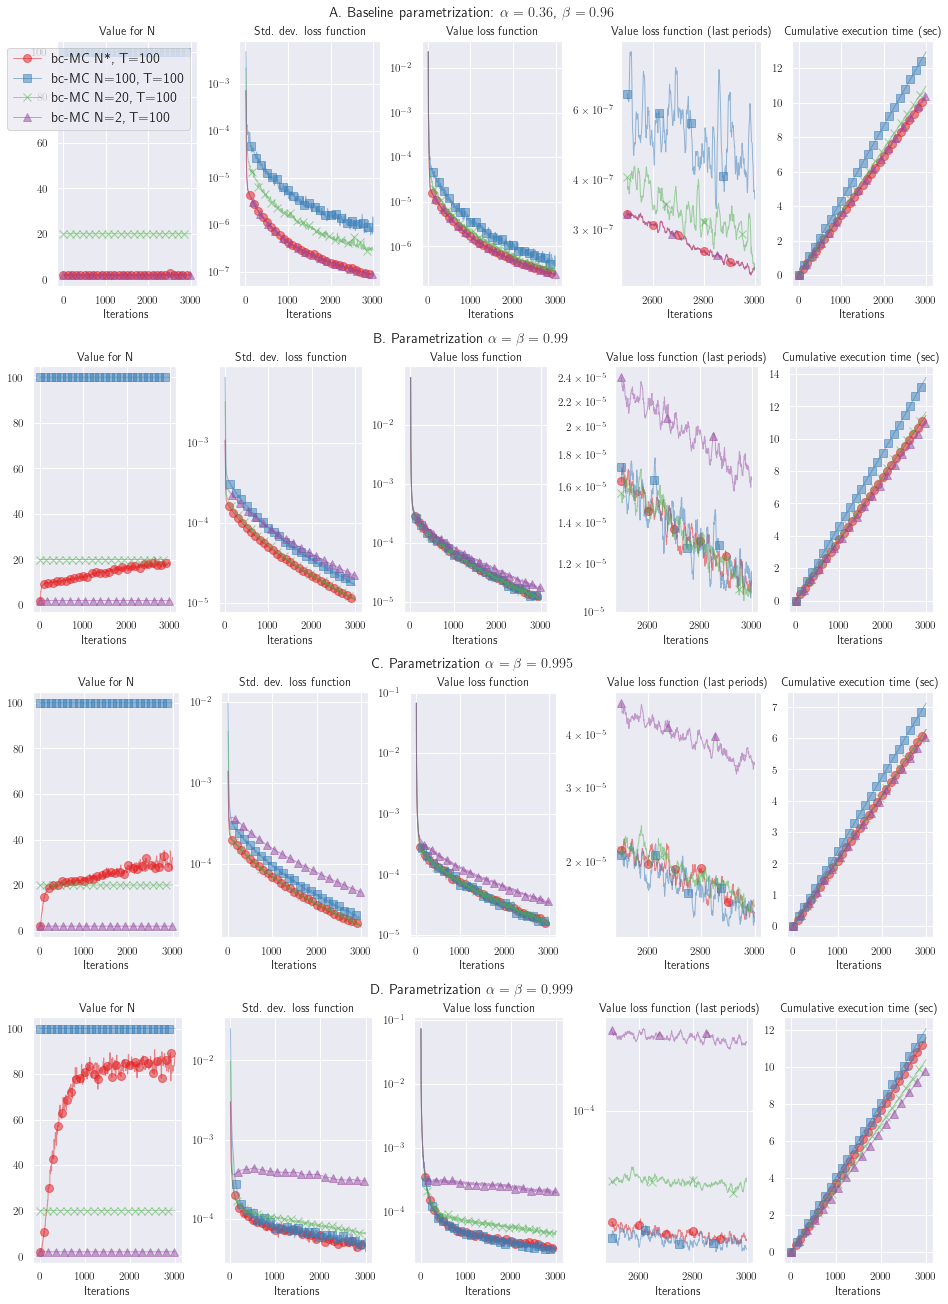

   sigma_e  alpha  beta optim   lr    N    M    T  N_star
0     0.05   0.36  0.96   SGD  2.0    2  100  100    True
1     0.05   0.36  0.96   SGD  2.0  100    2  100   False
2     0.05   0.36  0.96   SGD  2.0   20   10  100   False
3     0.05   0.36  0.96   SGD  2.0    2  100  100   False
   sigma_e  alpha  beta optim   lr    N    M    T  N_star
0     0.05   0.99  0.99   SGD  2.0    2  100  100    True
1     0.05   0.99  0.99   SGD  2.0  100    2  100   False
2     0.05   0.99  0.99   SGD  2.0   20   10  100   False
3     0.05   0.99  0.99   SGD  2.0    2  100  100   False
   sigma_e  alpha   beta optim   lr    N    M    T  N_star
0     0.05  0.995  0.995   SGD  2.0    2  100  100    True
1     0.05  0.995  0.995   SGD  2.0  100    2  100   False
2     0.05  0.995  0.995   SGD  2.0   20   10  100   False
3     0.05  0.995  0.995   SGD  2.0    2  100  100   False
   sigma_e  alpha   beta optim   lr    N    M    T  N_star
0     0.05  0.999  0.999   SGD  2.0    2  100  100    True
1     0

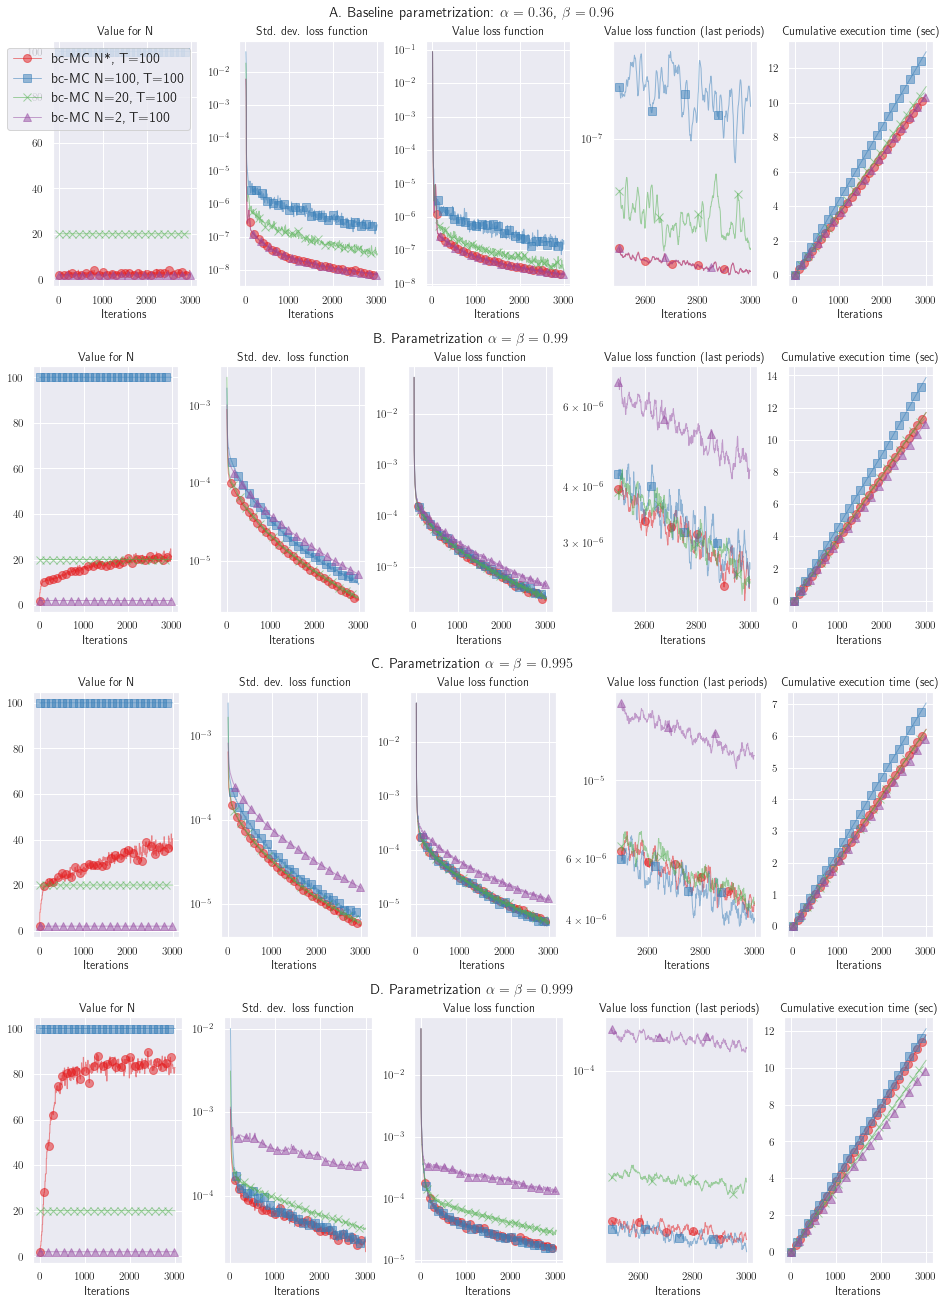

In [14]:
mult = 2
#Read all hyperparameters
extension_csv_file = "opt_N"
create_zoom = True #add a zoom on the last periods of losses
list_lr = []
list_optim = []
for nb in range(min_nb_plot, max_nb_plot):
    output_extension = f"BM_{nb}"
    local_path = os.getcwd() + f'/{output_extension}/file/content/output/{output_extension}/'
    df_hyperparams = pd.read_csv(local_path  + f'hyperparams_{extension_csv_file}.csv')
    list_lr.append(list(np.unique(df_hyperparams['lr'])))
    list_optim.append(list(np.unique(df_hyperparams['optim'])))
# make unique
list_lr = np.unique(list_lr)
list_optim = np.unique(list_optim)

# Define your subtitles
row_titles = [r'A. Baseline parametrization: $\alpha = 0.36$, $\beta = 0.96$', 
              r'B. Parametrization $\alpha = \beta = 0.99 $', 
              r'C. Parametrization $\alpha = \beta = 0.995 $', 
              r'D. Parametrization $\alpha = \beta = 0.999 $']


for optim_selected in list_optim:
    for lr_selected in list_lr: 
        plot_nb = -1 #initialization
        #fig, axs = plt.subplots(4, 4, figsize=(mult*6.5, mult*9)) #Single plot
        fig = plt.figure(constrained_layout=True, figsize=(mult*6.5, mult*9))
        (subfig0, subfig1, subfig2, subfig3) = fig.subfigures(4, 1) # create 4x1 subfigures

        graph_empty = True
        for nb in range(min_nb_plot, max_nb_plot):
            output_extension = f"BM_{nb}"
            output_folder = current_wd  + f"/output/{output_extension}/"

            # Load files
            local_path = os.getcwd() + f'/{output_extension}/file/content/output/{output_extension}/'

            if read_from_csv == True:
                #print("Reading CSV")

                df_hyperparams = pd.read_csv(local_path  + f'hyperparams_{extension_csv_file}.csv')
                #print(df_hyperparams)

                list_dfs_hyperparams = []
                for index, row in df_hyperparams.iterrows():
                    σ_e_chosen = row['sigma_e']
                    α_chosen = row['alpha']
                    β_chosen = row['beta']
                    optimizer_chosen = row["optim"]
                    lr_chosen = row["lr"]
                    N_chosen = row["N"]
                    M_chosen = row["M"]
                    use_N_star = row["N_star"]
                    # Save to disk
                    filen = local_path + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_σ_{σ_e_chosen}_α_{α_chosen}.csv'
                    list_dfs_hyperparams.append(pd.read_csv(filen))


            list_combinations_used = []
            for index, row in df_hyperparams.iterrows():
                σ_e_chosen = row['sigma_e']
                α_chosen = row['alpha']
                β_chosen = row['beta']
                optimizer_chosen = row["optim"]
                lr_chosen = row["lr"]
                N_chosen = row["N"]
                M_chosen = row["M"]
                use_N_star = row["N_star"]


                combination = f'{optimizer_chosen}-{σ_e_chosen}-{α_chosen}-{β_chosen}-{lr_chosen}'
                if combination not in list_combinations_used:
                    list_combinations_used.append(combination)
                else:
                    continue #If combination already used, pass

                # Pass if lr
                if (lr_chosen != lr_selected) | (optimizer_chosen != optim_selected):
                    continue
                else: 
                    graph_empty = False
                    plot_nb+=1
                    if plot_nb>3:
                        break

                df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
                df_sel = df_sel[df_sel["sigma_e"] == σ_e_chosen]
                df_sel = df_sel[df_sel["alpha"] == α_chosen]
                df_sel = df_sel[df_sel["beta"] == β_chosen]
                df_sel = df_sel[df_sel["lr"] == lr_chosen]
                print(df_sel)


                list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
                list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
                list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
                list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
                list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

                list_labels = []
                for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                    if N_star == True:
                        list_labels += [f"bc-MC N*, T={T}"]
                    else:
                        list_labels += [f"bc-MC N={N}, T={T}"]
                #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

                if create_zoom == False:
                    (ax1, ax2, ax3, ax5) =  eval(f"subfig{plot_nb}.subplots(1, 4)")
                else:
                    (ax1, ax2, ax3, ax4, ax5) =  eval(f"subfig{plot_nb}.subplots(1, 5)")
                    
                eval(f"subfig{plot_nb}.suptitle(row_titles[{plot_nb}])")
                # fig.suptitle('Figure title')            # set global suptitle if desired

                #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
                for (i, (min_index, max_index)) in enumerate(zip([0], [3000])):
                    #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
                    #fig, (ax1, ax2, ax3, ax5) = plt.subplots(1, 4)

                    var = "optimal_N"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                    #ax1.set_yscale('log')
                    ax1.set_title('Value for N')
                    if plot_nb == 0:
                        ax1.legend(loc="upper right")
                    ax1.set_xlabel("Iterations")

                    var = "var_loss"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                    ax2.set_yscale('log')
                    ax2.set_title('Std. dev. loss function')
                    #ax2.legend(loc="upper right")
                    ax2.set_xlabel("Iterations")

                    var = "loss"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                    ax3.set_yscale('log')
                    #ax3.set_xscale('log')
                    ax3.set_title('Value loss function')
                    ax3.set_xlabel("Iterations")

                    if create_zoom == True:
                        min_index_local = 2500 #1500 
                        max_index_local = 3000 #2000
                        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                            ax4.plot(df["iter"][min_index_local:max_index_local], MA_series[min_index_local:max_index_local], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                            if display_CI==True:
                                ax4.fill_between(df["iter"][min_index_local:max_index_local], MA_series[min_index_local:max_index_local] - mult*MA_std[min_index_local:max_index_local], MA_series[min_index_local:max_index_local] + mult*MA_std[min_index_local:max_index_local], color=c, alpha=alpha_bands)
                        ax4.set_yscale('log')
                        #ax3.set_xscale('log')
                        ax4.set_title('Value loss function (last periods)')
                        ax4.set_xlabel("Iterations")
                    
                    var = "time"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

                    ax5.set_xlabel("Iterations")
                    ax5.set_title("Cumulative execution time (sec)")

        if graph_empty == False:
            figname = os.getcwd() + f'/output/{extension_csv_file}_lr_{lr_selected}_optim_{optim_selected}_one_page_zoom_{create_zoom}.png'
            plt.savefig(figname, bbox_inches="tight", dpi=300)

            figname = os.getcwd() + f'/output/{extension_csv_file}_lr_{lr_selected}_optim_{optim_selected}_one_page_{create_zoom}.pdf'
            plt.savefig(figname, bbox_inches="tight", dpi=600)
            plt.show()